In [1]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.3 MB/s 
     |████████████████████████████████| 451 kB 79.2 MB/s 
     |████████████████████████████████| 7.6 MB 53.2 MB/s 
     |████████████████████████████████| 182 kB 78.5 MB/s 
     |████████████████████████████████| 132 kB 79.8 MB/s 
     |████████████████████████████████| 212 kB 82.2 MB/s 
     |████████████████████████████████| 127 kB 77.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import string

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device(device)
print(device)
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i=torch.range(1,n_dest)[:,None]
    j=torch.range(1,n_src)
    m = i >= j - n_src + n_dest
    mask=m.bool()
    return ~mask
#     mask=torch.reshape(mask, [1, n_dest, n_src])
#     mult=[batch_size,1,1]
#     return torch.tile(mask,mult);

def padding_mask(input):
    # Create mask which marks the zero padding values in the input by a 1
#     print(input)
#     input=torch.tensor(input['train']['input_ids'])
    mask=torch.eq(input, torch.zeros_like(input))

 
    return mask

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads,batch_first,rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads,batch_first=batch_first)

    def forward(self, inputs,pad_mask):
        input_shape = inputs.size()
        batch_size = input_shape[0]
        seq_len = input_shape[1]
#         pad_mask=padding_mask(inputs)
        pad_mask.to(device)
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, torch.bool).to(device)
        attention_output,a = self.attention(inputs, inputs,inputs, key_padding_mask=pad_mask, attn_mask=causal_mask,need_weights=True,average_attn_weights=False)
        return attention_output,a

class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim,max_norm=1)
        self.pos_emb = nn.Embedding(maxlen,embed_dim)

    def forward(self, x):
        maxlen = x.size()[-1]
        pad_mask=padding_mask(x)
        positions = torch.range(start=0, end=maxlen-1, step=1,dtype=torch.int32).to(device)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return (x + positions),pad_mask

vocab_size =50257 #28996  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim,True)
        self.outputs= nn.LazyLinear(vocab_size)
        
    def forward(self, x):
        x,pad_mask = self.embedding_layer(x)
#         print(x,"maximum=",torch.max(x))
        x,a = self.transformer_block(x,pad_mask)
#         print(x)
        x = self.outputs(x)
        
        return x,a


cuda:0


In [4]:
model = Model()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
from datasets import load_dataset

dataset = load_dataset("wikitext","wikitext-103-raw-v1", split="test")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


In [7]:
dataset

Dataset({
    features: ['text'],
    num_rows: 4358
})

In [8]:
import pandas as pd
import os
import re
# directories = [
#     "/kaggle/input/aclimdb-v1/aclImdb/train/pos",
#     "/kaggle/input/aclimdb-v1/aclImdb/train/neg",
#     "/kaggle/input/aclimdb-v1/aclImdb/test/pos",
#     "/kaggle/input/aclimdb-v1/aclImdb/test/neg",
# ]

# from datasets import load_dataset
# filenames = []
# for dir in directories:
#     for f in os.listdir(dir):
#         filenames.append(os.path.join(dir, f))

# dataset = load_dataset("text", data_files=filenames)

def processing(s):
  s['text']=s['text'].lower()
  s['text']=re.sub("<br />", " ", s['text'])
  s['text']=re.sub(f"([{string.punctuation}])", r" \1", s['text'])
  return s

dataset=dataset.map(processing)

dataset = dataset.filter(lambda example: example['text']!="")

dataset = dataset.map(lambda dataset: tokenizer(dataset["text"],truncation=True, max_length=maxlen))

def padding(s):
    if len(s['input_ids'])<maxlen :
        s['input_ids']=s['input_ids']+[0]*(maxlen-len(s['input_ids']))
    return s
                                           
dataset=dataset.map(padding)

from datasets import Dataset
train_dataset= Dataset.from_dict({"id": dataset['input_ids']})
train_dataset = train_dataset.with_format("torch")

count=0
TEST=[]
train_loader=DataLoader(train_dataset,batch_size=50,shuffle=True)
for i in train_loader:
    TEST.append(random.choice(i['id']))
    if count>100:
        break
    count+=1

TEST=torch.stack(TEST,0) 
# print(TEST[:,:])

  0%|          | 0/4358 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2891 [00:00<?, ?ex/s]

  0%|          | 0/2891 [00:00<?, ?ex/s]

In [9]:
class TextGenerator(nn.Module):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
#         self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = torch.topk(logits, k=self.k, sorted=True)
        logits=logits.cpu()
        indices=indices.cpu()
        indices = np.asarray(indices).astype("int32")
       
        softmax=nn.Softmax(dim=0)
        preds = softmax(logits)
        preds = np.asarray(preds).astype("float32")
#         return np.random.choice(indices, p=preds) THIS IS THE CORRECT CODE, BUT HAD TO COMMENT IT AS
#.        PROBABILITIES HAVE NAN AND I HAD TO VERIFY PIPELINE, BELOW LINE WILL BE REMOVED ONCE NAN ISSUE 
#.        IS RESOLVED
        return np.random.choice(indices, p=preds)
#         return np.random.choice(5, 1, p=[0.1, 0, 0.3, 0.6, 0])

    def detokenize(self, number):
        return tokenizer.decode(number)

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        attention_scores=[]
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                data = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                data = start_tokens + [0] * pad_len
            else:
                data = start_tokens
                
            data = torch.Tensor(np.array([data])).type(torch.int32).to(device)
            
            y,attention_scores = model(data)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        ret_txt = [self.detokenize(_) for _ in self.start_tokens + tokens_generated + [0]*(pad_len-1)]
        print(tokens_generated)
        print(len(tokens_generated))
        print(f"generated text:\n{txt}\n")
        return attention_scores[0], ret_txt

# Tokenize starting prompt
# word_to_index = {}
# for index, word in enumerate(vocab):
#     word_to_index[word] = index

start_prompt = "this movie is"
start_tokens=tokenizer(start_prompt)['input_ids']
# start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
# text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [10]:
x_list = [1, 6, 11, 15]

In [11]:
loss_fn=torch.nn.CrossEntropyLoss()
loss_stats = {
    'test': [],
}
for i in x_list:
    model.load_state_dict(torch.load(f"/content/transformer_weights_{i}.pth"))
    model = model.to(device)
    with torch.no_grad():
        TextGenerator(40, start_tokens).on_epoch_end(i);
        test_input=TEST[:,:-1].to(device)
        test_output=TEST[:,1:].to(device)
        outputs,attention_scores=model.forward(test_input)
        labels=nn.functional.one_hot(test_output,num_classes=vocab_size).type(torch.float)
        loss=loss_fn(outputs,labels).cpu().item()
        loss_stats['test'].append(loss)

<ipython-input-3-93b14399b347>:52: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  positions = torch.range(start=0, end=maxlen-1, step=1,dtype=torch.int32).to(device)
<ipython-input-3-93b14399b347>:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  i=torch.range(1,n_dest)[:,None]
<ipython-input-3-93b14399b347>:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  j=torch.range(1,n_src)


[3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273, 3273]
41
generated text:
this  movie  is cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember cember

[1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058]
41
generated text:
this  movie  is  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :

[1058, 1058, 1058, 1058,

In [12]:
test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


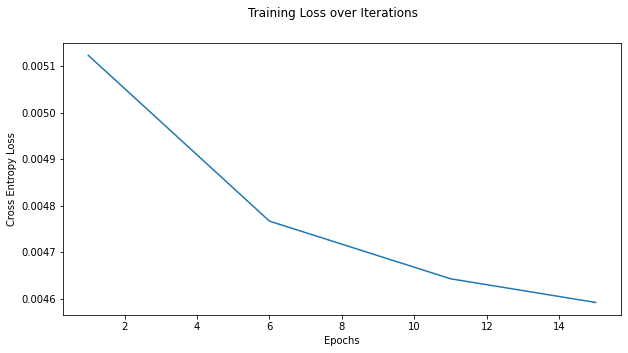

In [13]:
fig = plt.figure(figsize=[10, 5])
plt.plot(x_list, test_loss_df["value"])
fig.suptitle('Training Loss over Iterations')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
fig.savefig('training_loss_curve.jpg')

In [14]:
len(dataset)

2891

In [15]:
models = {}
for x in x_list:
    model = Model()
    model.load_state_dict(torch.load(f"transformer_weights_{x}.pth"))
    models[x] = model.to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
running_loss = {x: 0 for x in x_list}
# models = {x: Model().load_state_dict(torch.load(f"transformer_weights_{x}.pth")) for x in [0, 10, 15, 20, 25, 30, 35]}
for batch in tqdm(train_loader):
    for x in x_list:
        with torch.no_grad():
        #         print(batch['id'][:,:-1])
            input_ids=batch['id'][:,:-1].to(device)
        #         print(input_ids.shape())
            labels=batch['id'][:,1:].to(device)
            outputs,attention_scores=models[x].forward(input_ids)
            labels=nn.functional.one_hot(labels,num_classes=vocab_size).type(torch.float)
            loss=loss_fn(outputs,labels)
            running_loss[x] += loss
loss /= len(dataset)

  0%|          | 0/58 [00:00<?, ?it/s]

<ipython-input-3-93b14399b347>:52: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  positions = torch.range(start=0, end=maxlen-1, step=1,dtype=torch.int32).to(device)
<ipython-input-3-93b14399b347>:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  i=torch.range(1,n_dest)[:,None]
<ipython-input-3-93b14399b347>:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  j=torch.range(1,n_src)


In [17]:
running_loss

{1: tensor(0.3031, device='cuda:0'),
 6: tensor(0.2838, device='cuda:0'),
 11: tensor(0.2765, device='cuda:0'),
 15: tensor(0.2731, device='cuda:0')}

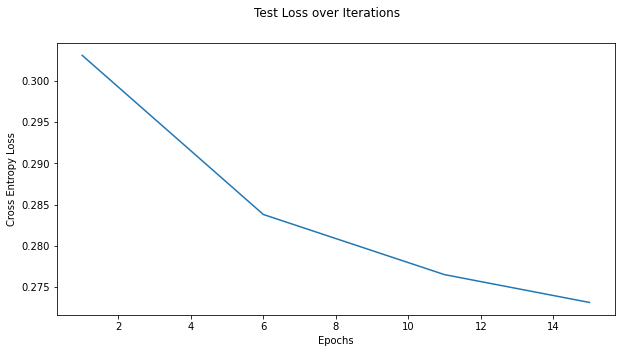

In [18]:
fig = plt.figure(figsize=[10, 5])
plt.plot(list(running_loss.keys()), list(map(lambda x: x.cpu().numpy(), running_loss.values())))
fig.suptitle('Test Loss over Iterations')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
fig.savefig('test_loss_curve.jpg')


In [19]:
model = models[x_list[-1]]

In [20]:
with torch.no_grad():
    score, ret_txt=TextGenerator(5, start_tokens).on_epoch_end(5);
score=score.cpu().numpy()

[1058, 1058, 1058, 1058, 1058, 1058]
6
generated text:
this  movie  is  :  :  :  :  :  :



<ipython-input-3-93b14399b347>:52: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  positions = torch.range(start=0, end=maxlen-1, step=1,dtype=torch.int32).to(device)
<ipython-input-3-93b14399b347>:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  i=torch.range(1,n_dest)[:,None]
<ipython-input-3-93b14399b347>:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  j=torch.range(1,n_src)


In [21]:
score.shape

(8, 80, 80)

In [22]:
len(start_tokens)

3

In [23]:
score[0,:18, :18]

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00154061, 0.99845946, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00110624, 0.28620517, 0.71268857, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00235177, 0.26904064, 0.18347871, 0.5451289 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
    

In [24]:
ret_txt

['this',
 ' movie',
 ' is',
 ' :',
 ' :',
 ' :',
 ' :',
 ' :',
 ' :',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!',
 '!']

In [25]:
score.shape

(8, 80, 80)

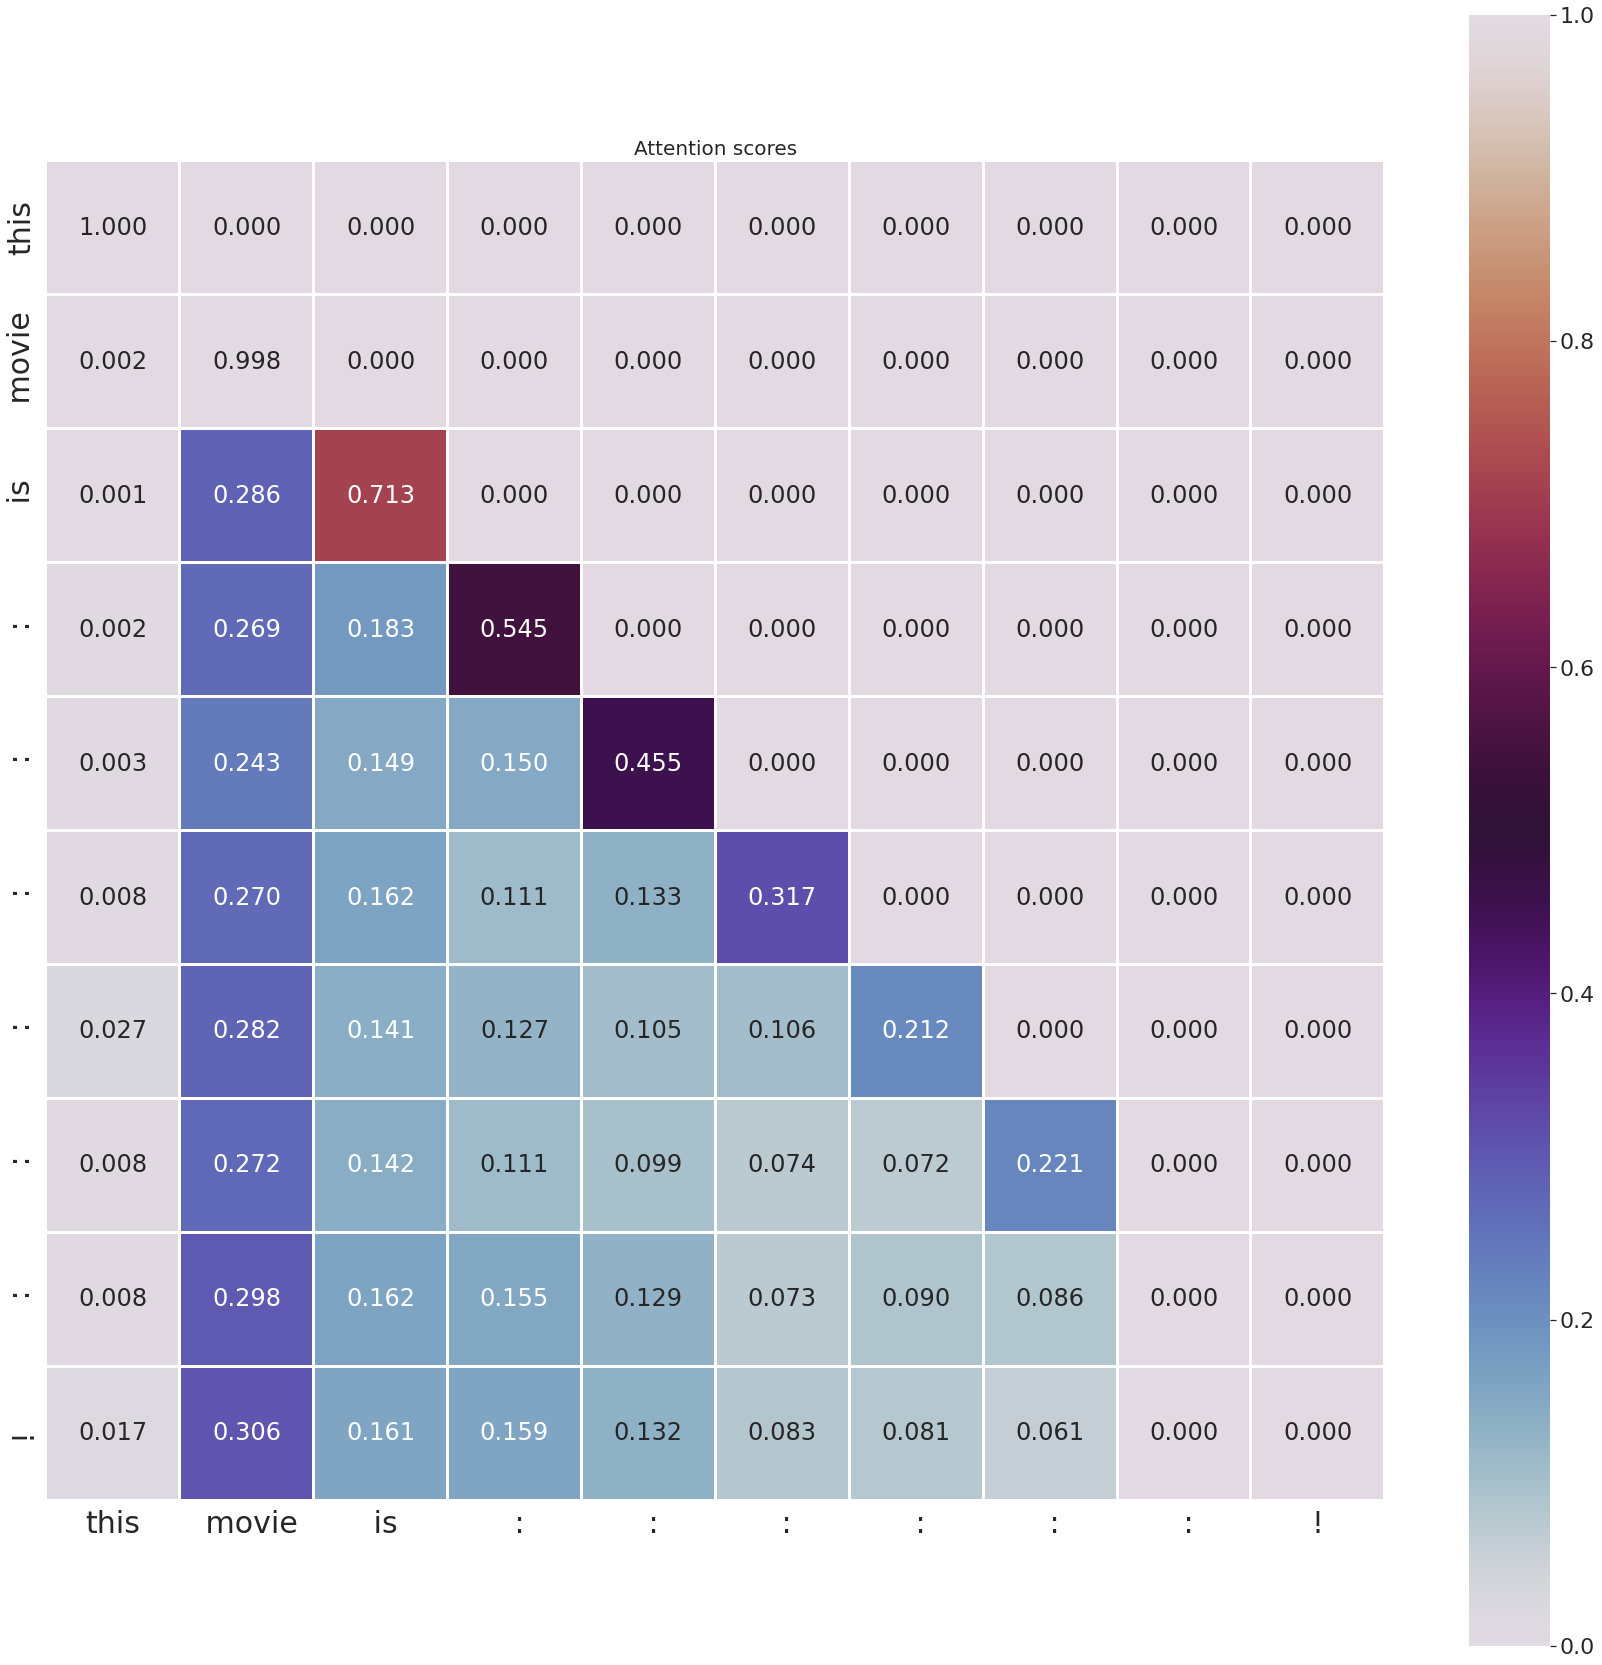

In [27]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[0, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores", fontsize=20);
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_0.jpg")

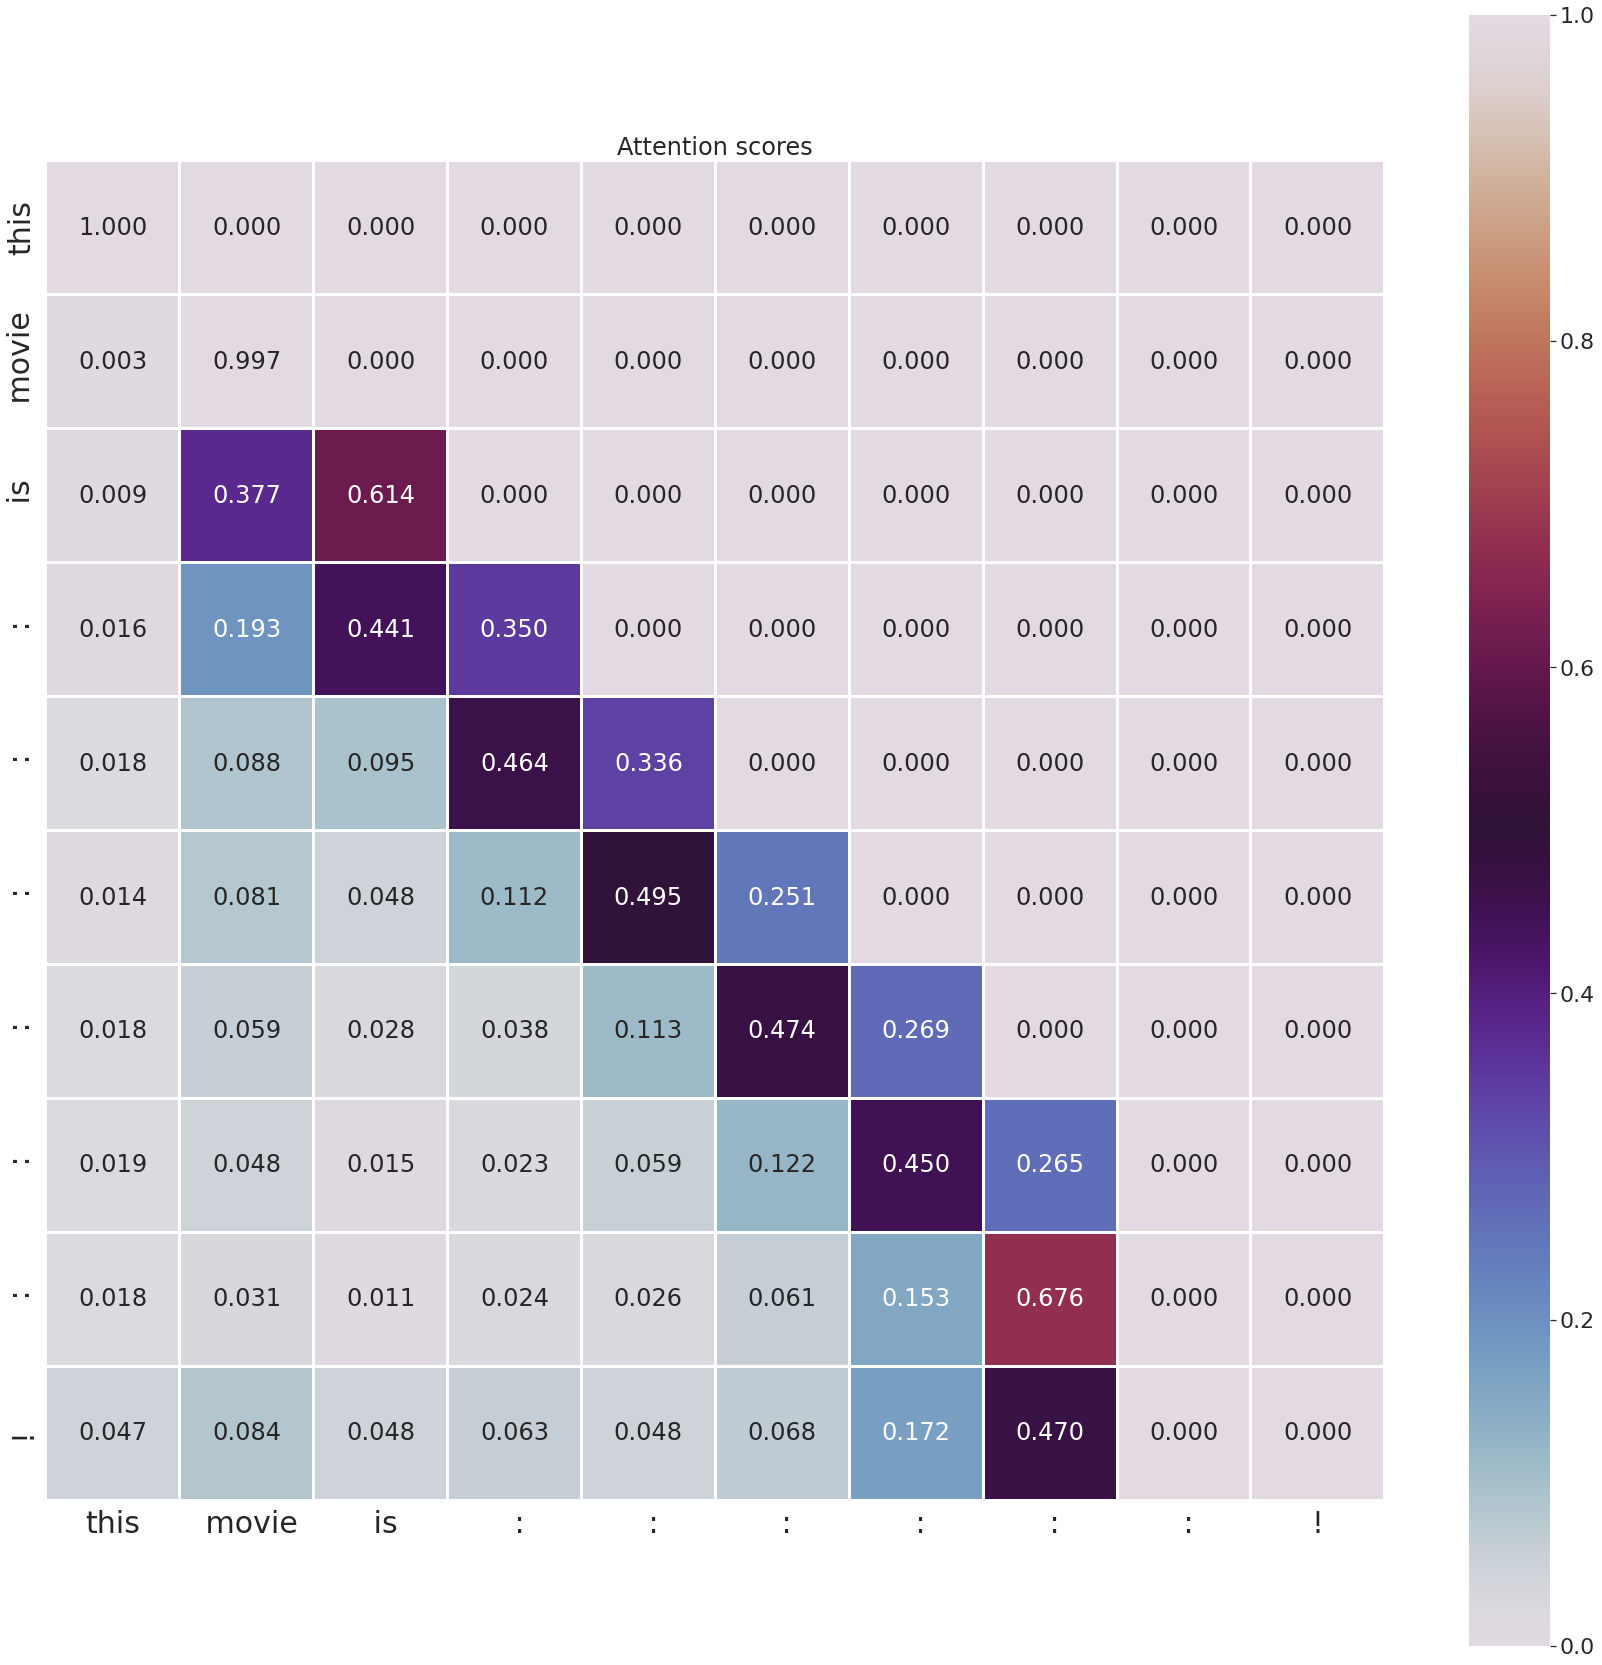

In [28]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[1, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_1.jpg")

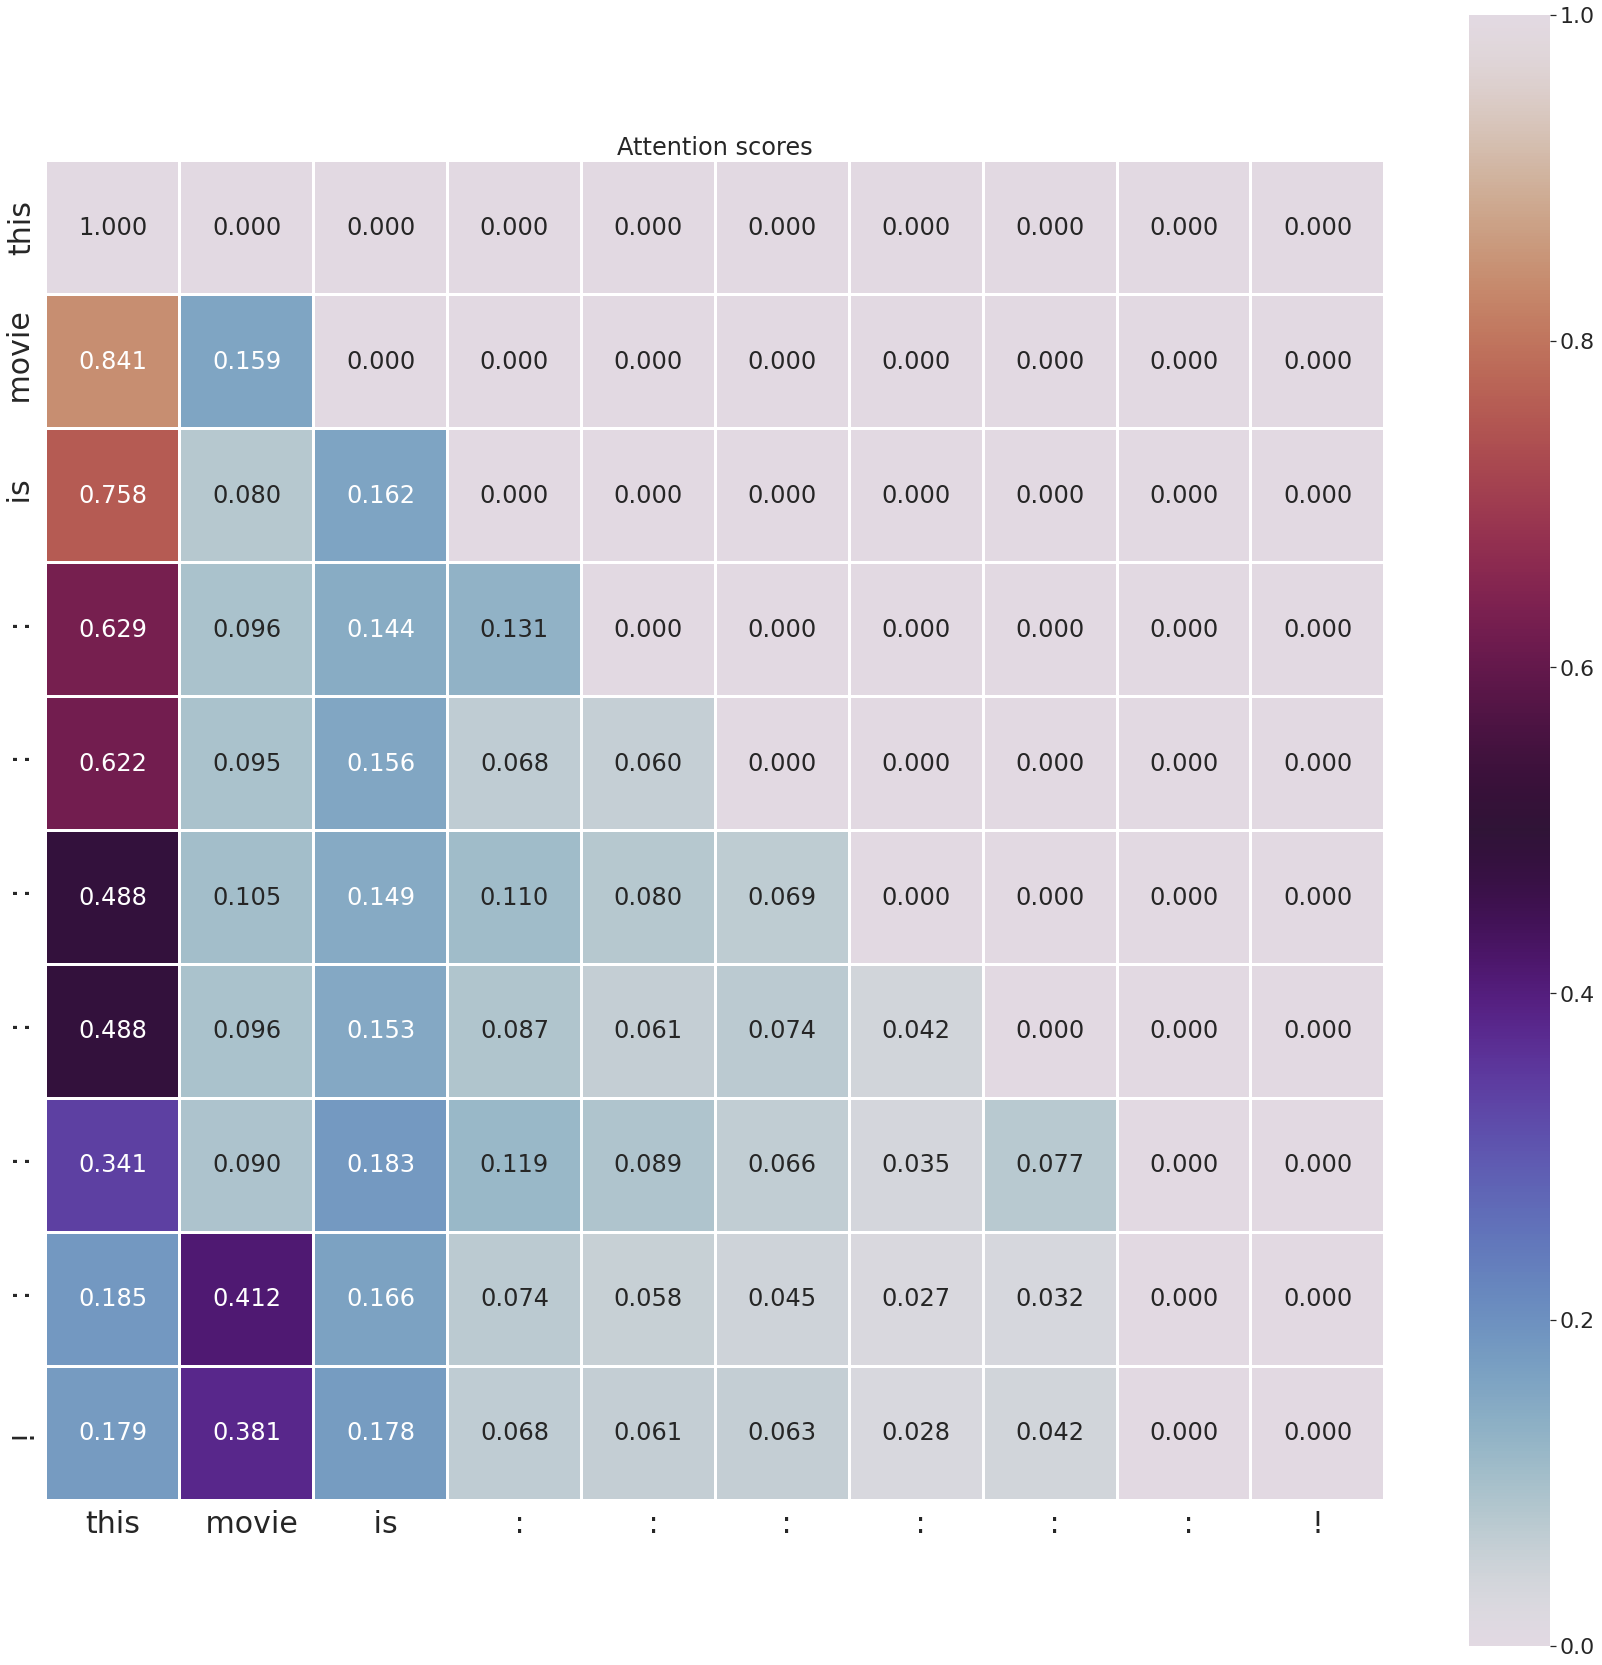

In [29]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[3, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_2.jpg")

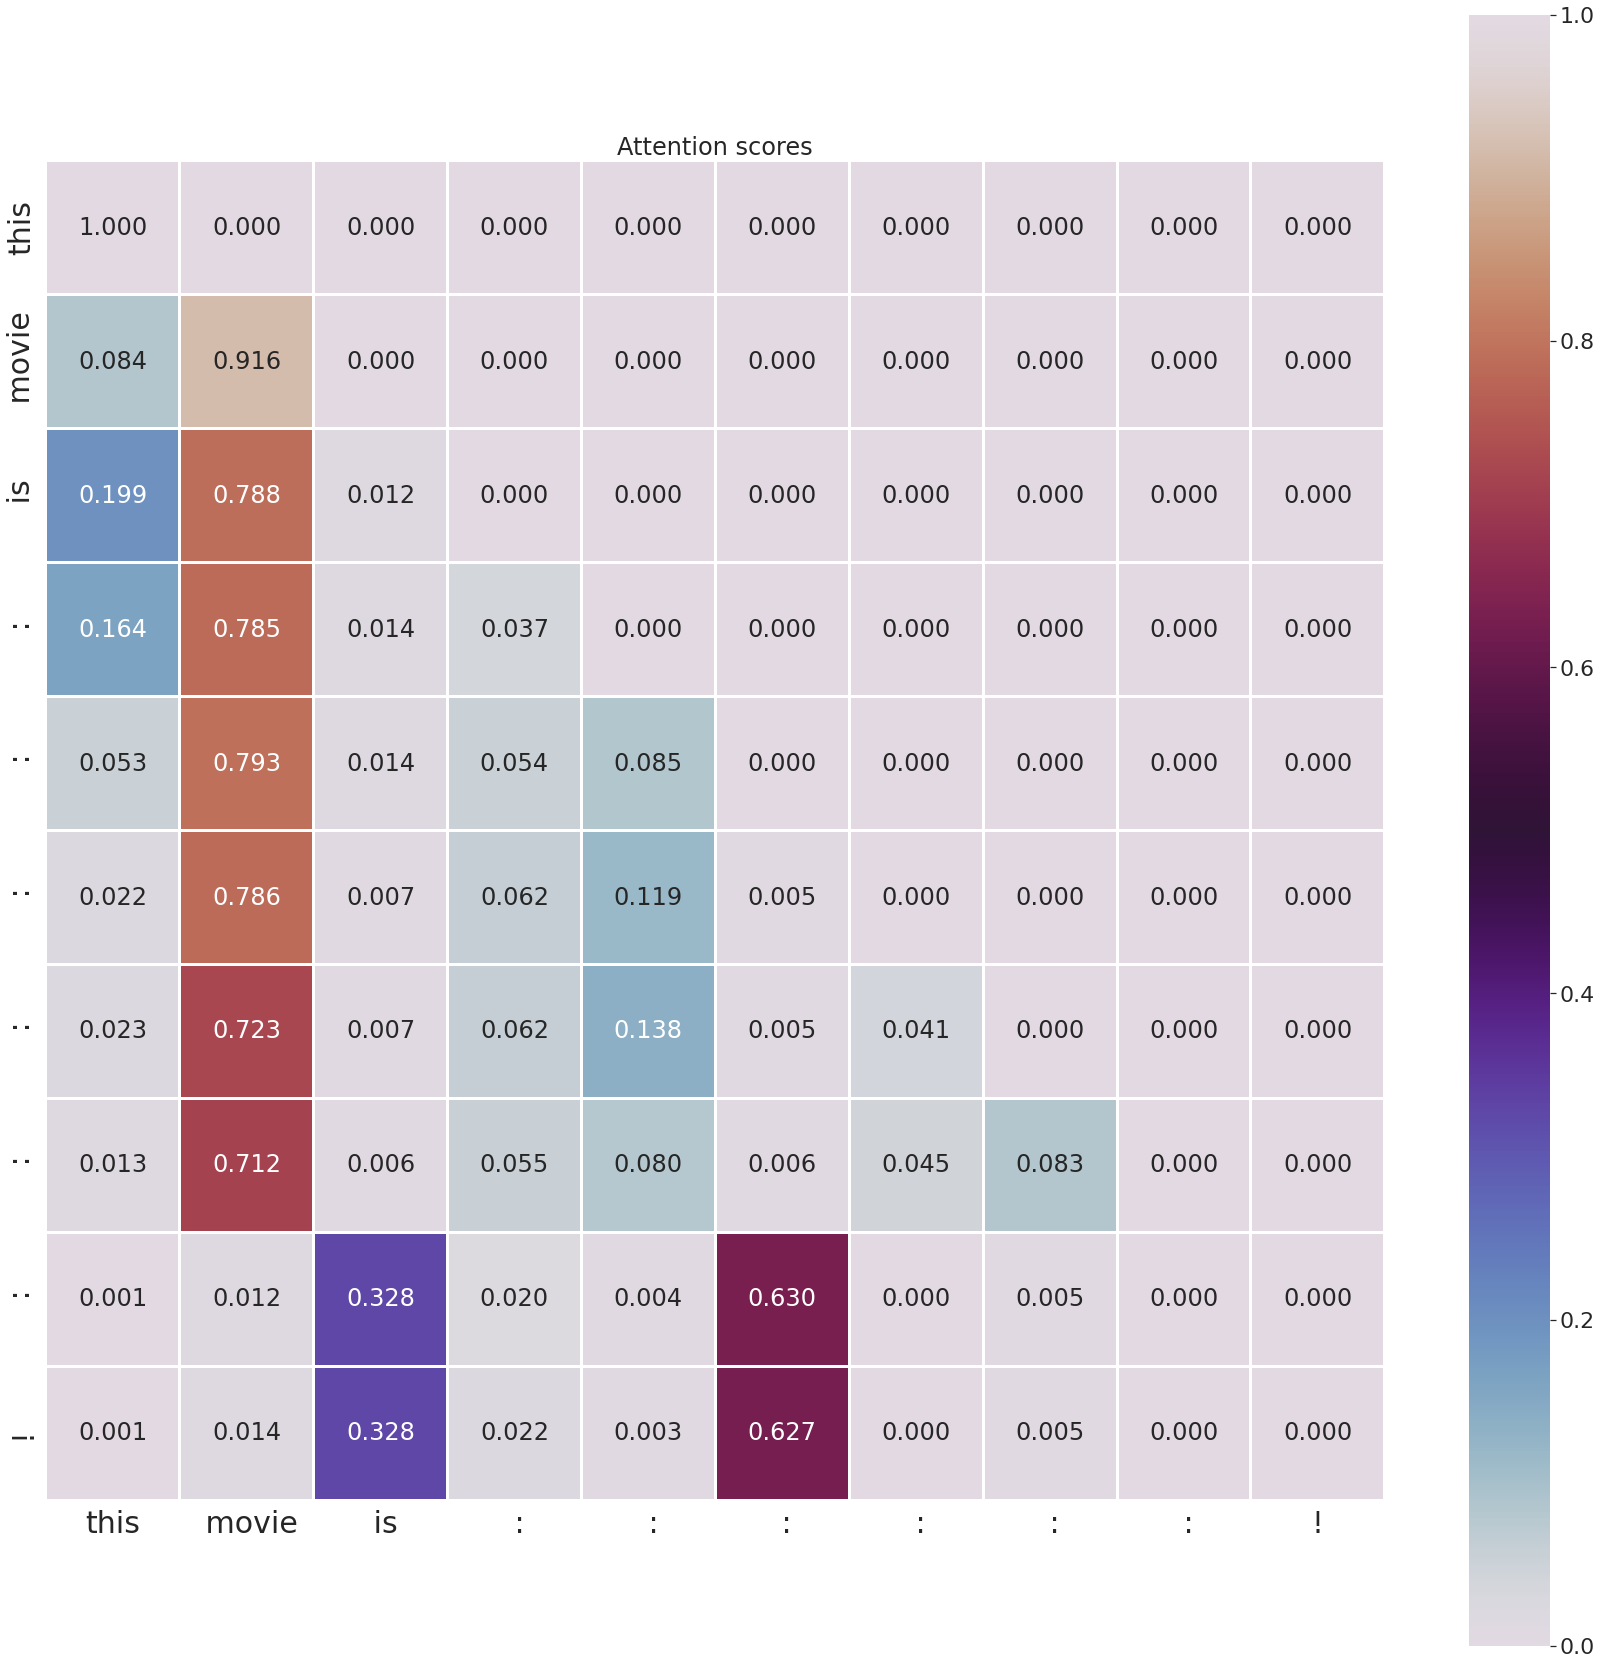

In [30]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[4, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_3.jpg")

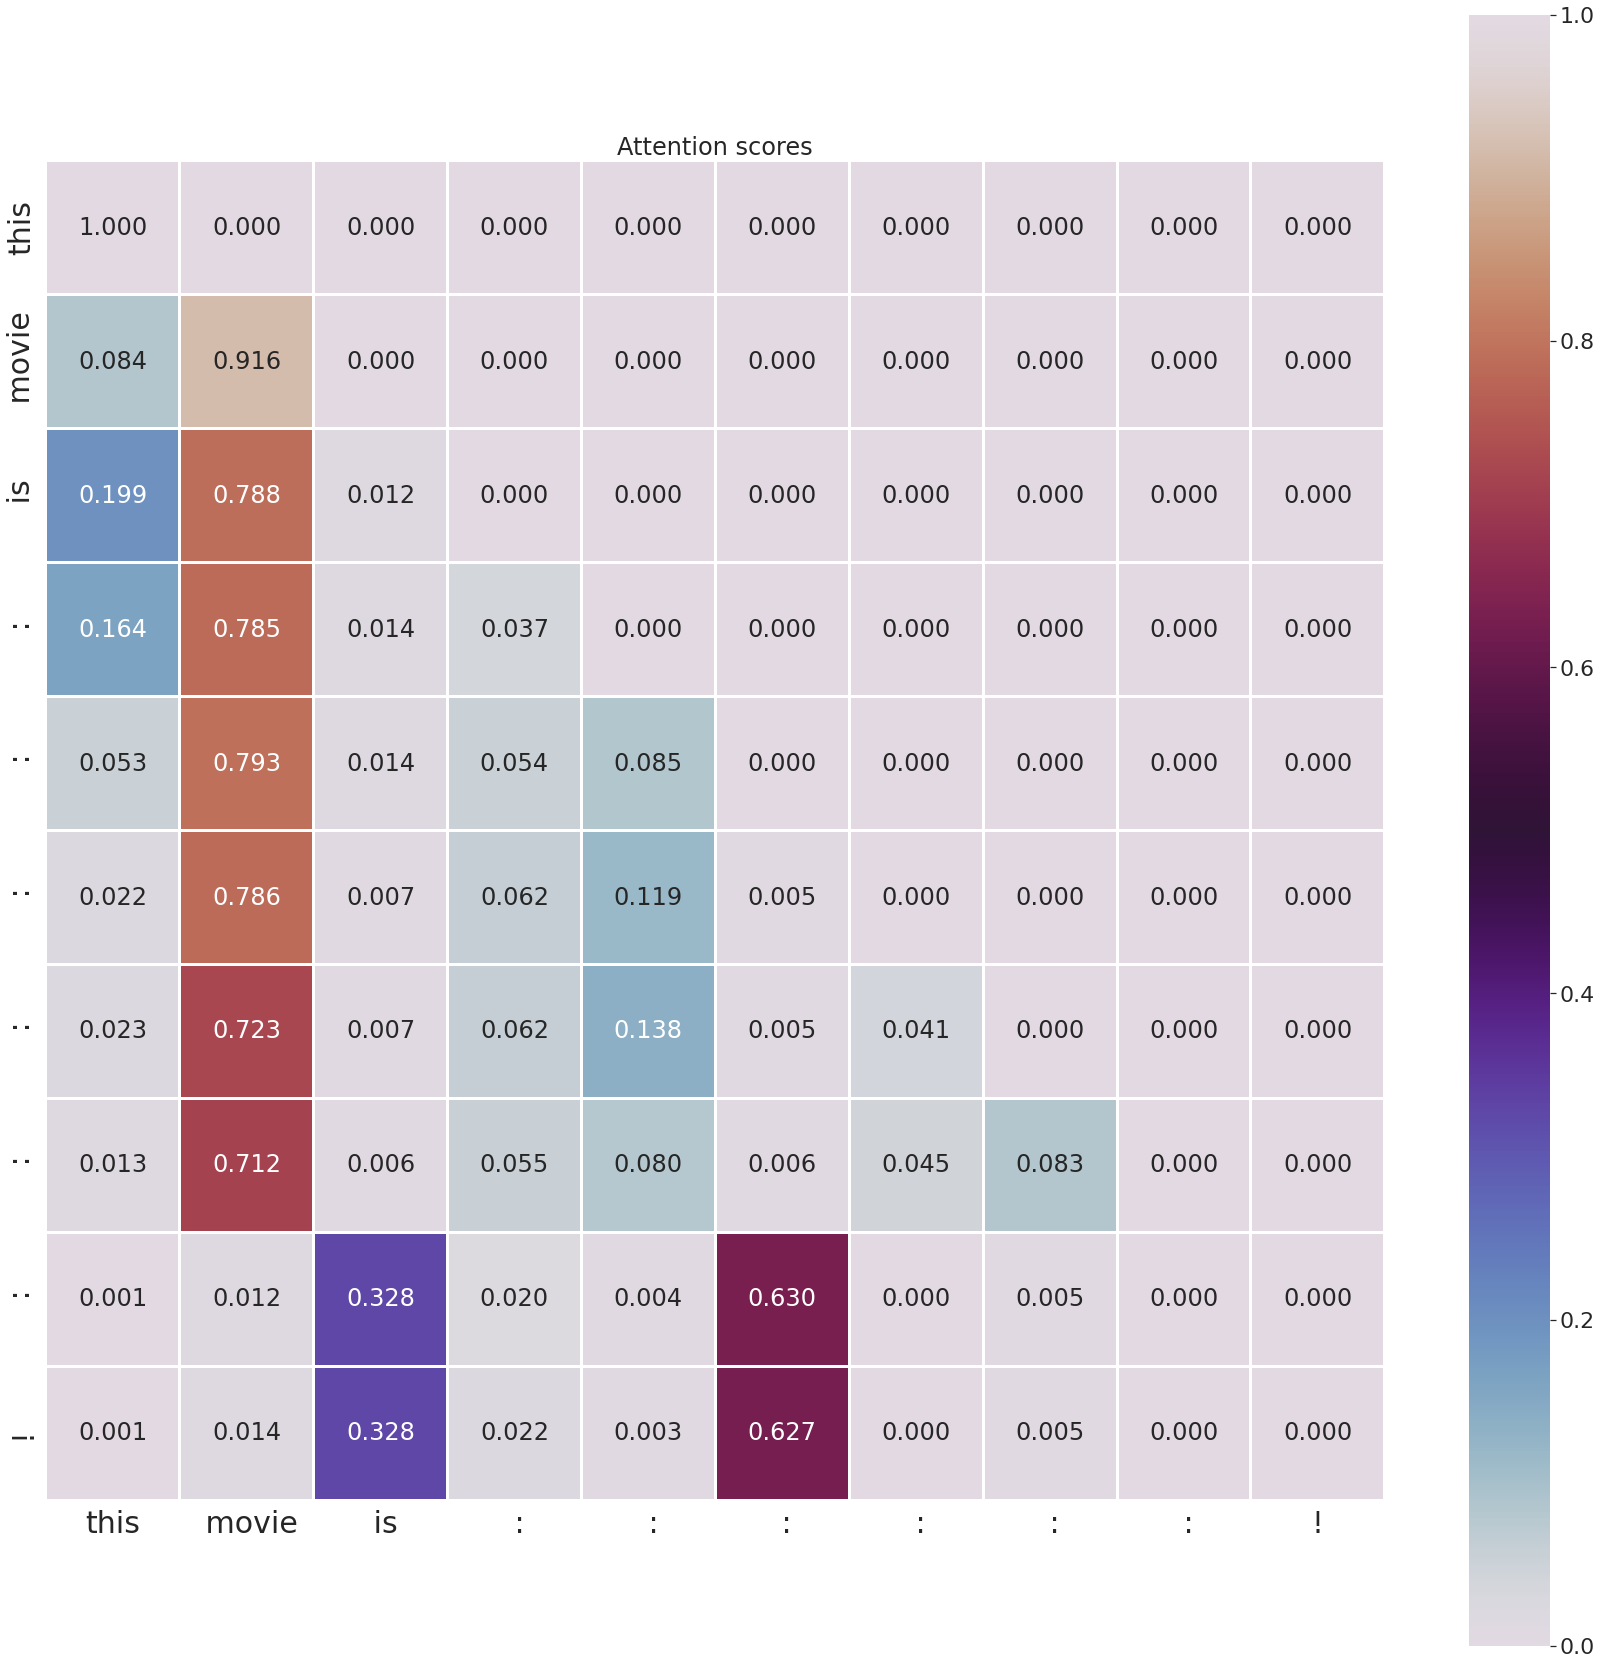

In [31]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[4, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_4.jpg")

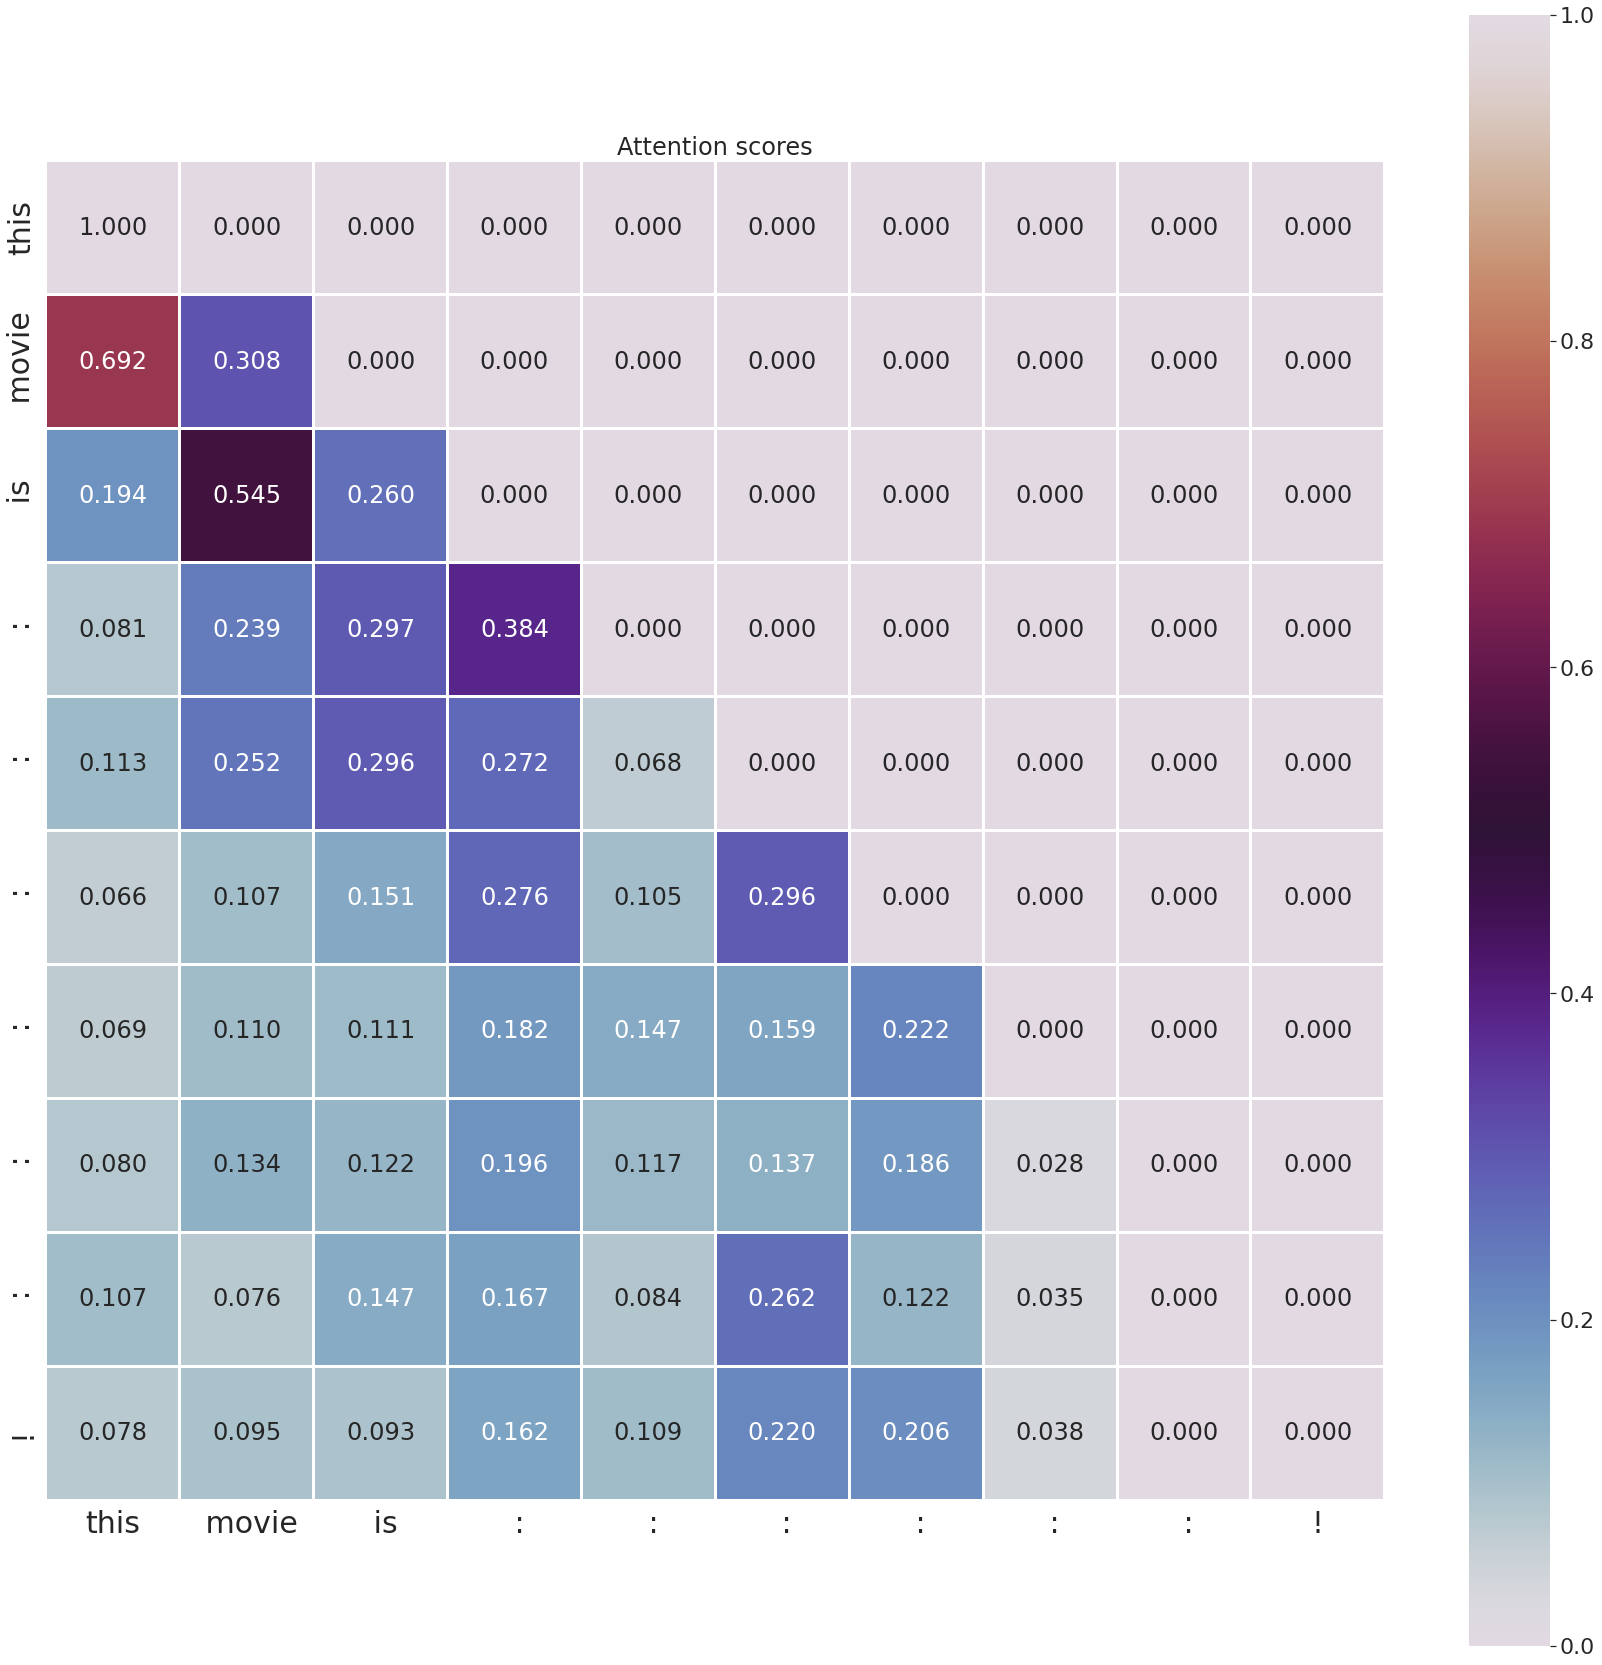

In [32]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[5, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_5.jpg")

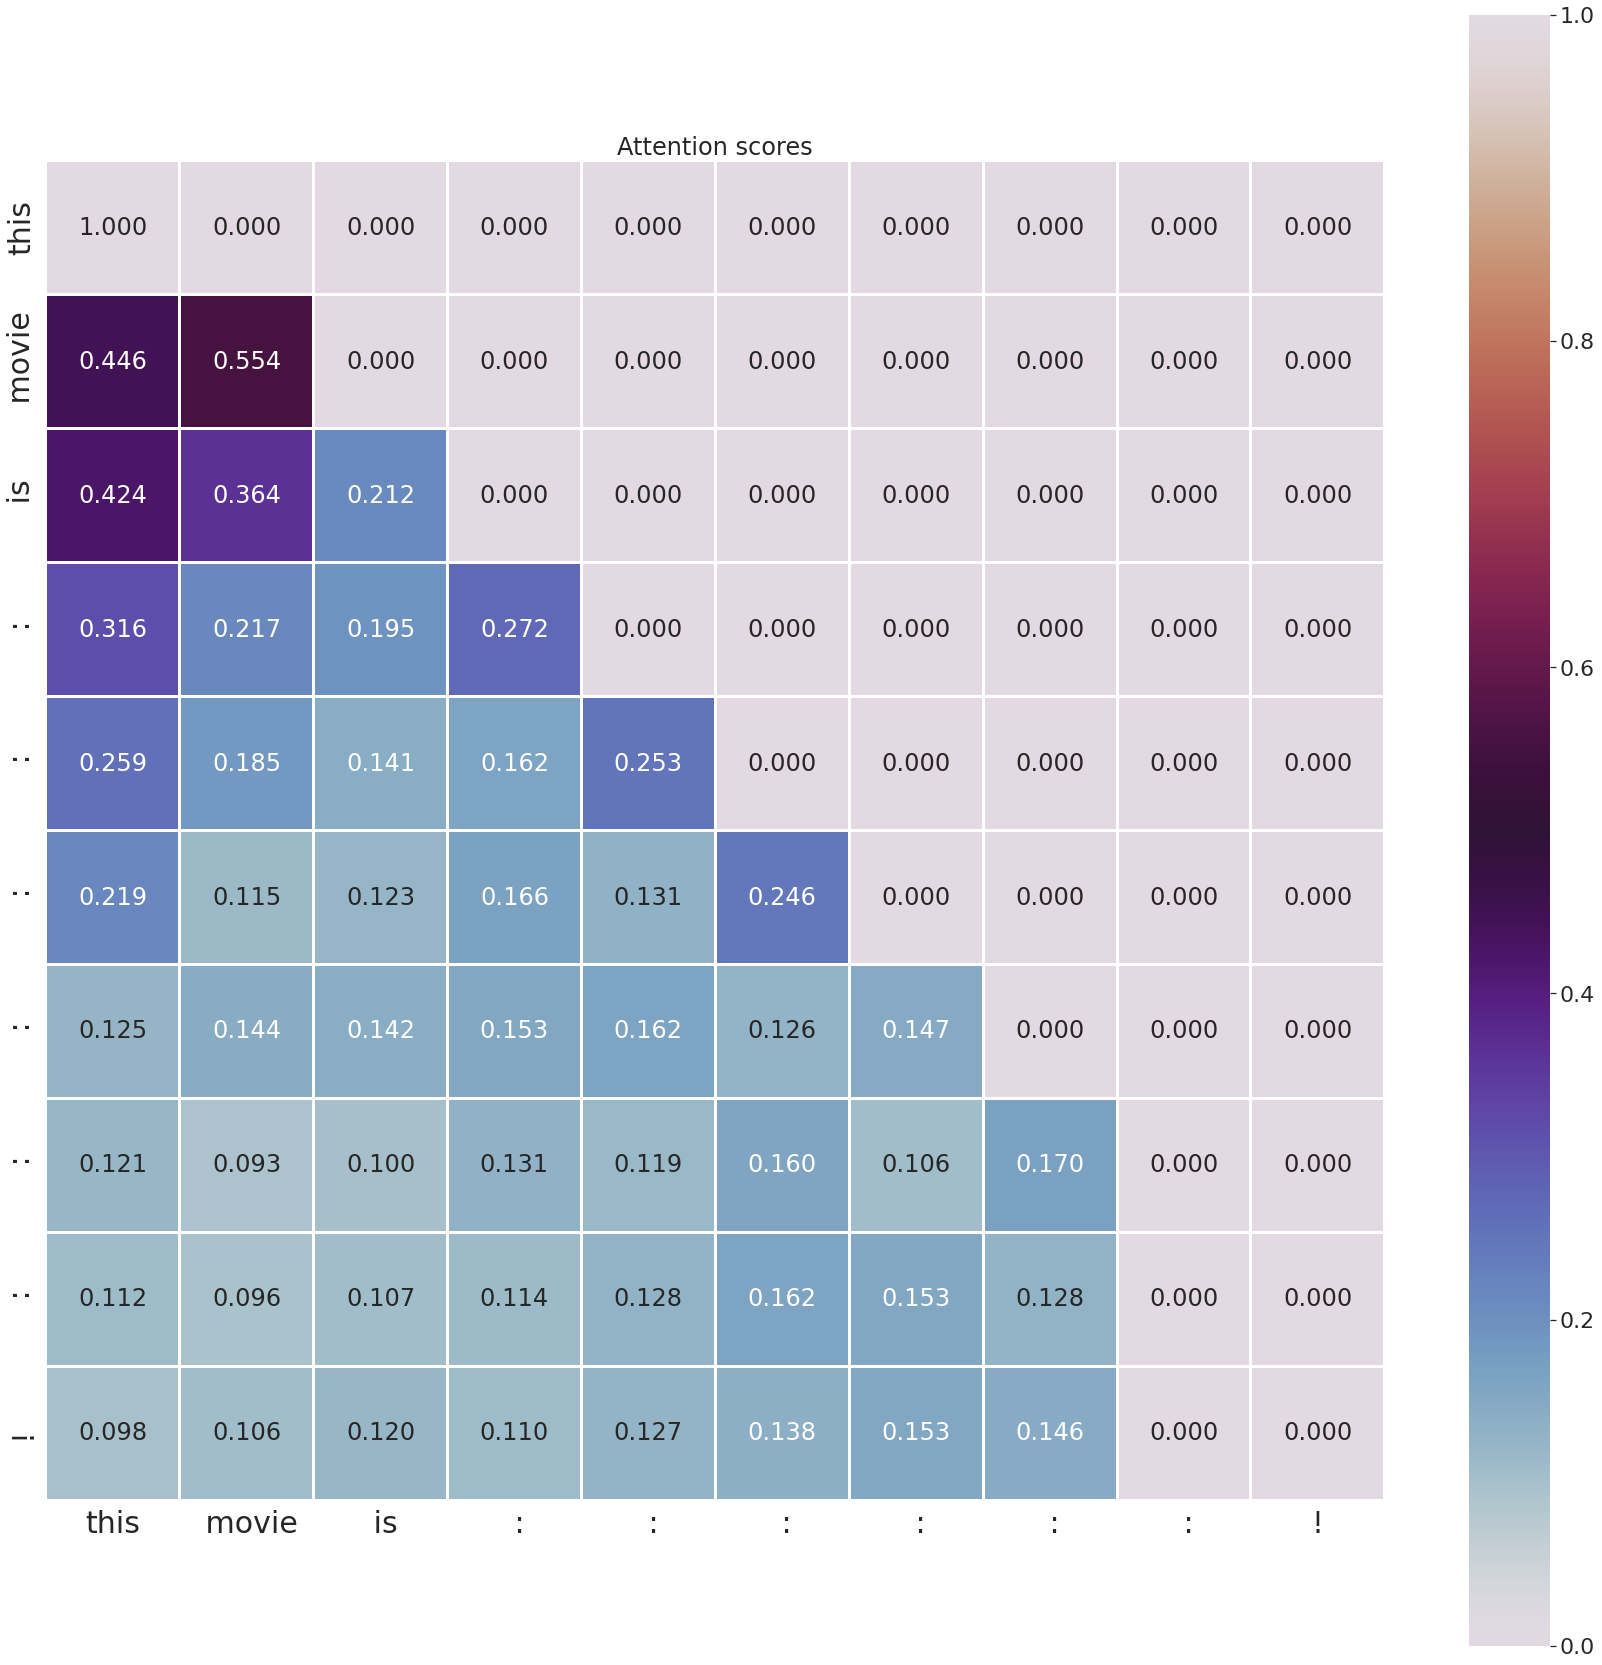

In [33]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[6, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen);
plt.ylabel('Queries',size=maxlen);
plt.plot();
sns.set(font_scale=2)
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
plt.savefig("./attn/attn_6.jpg")

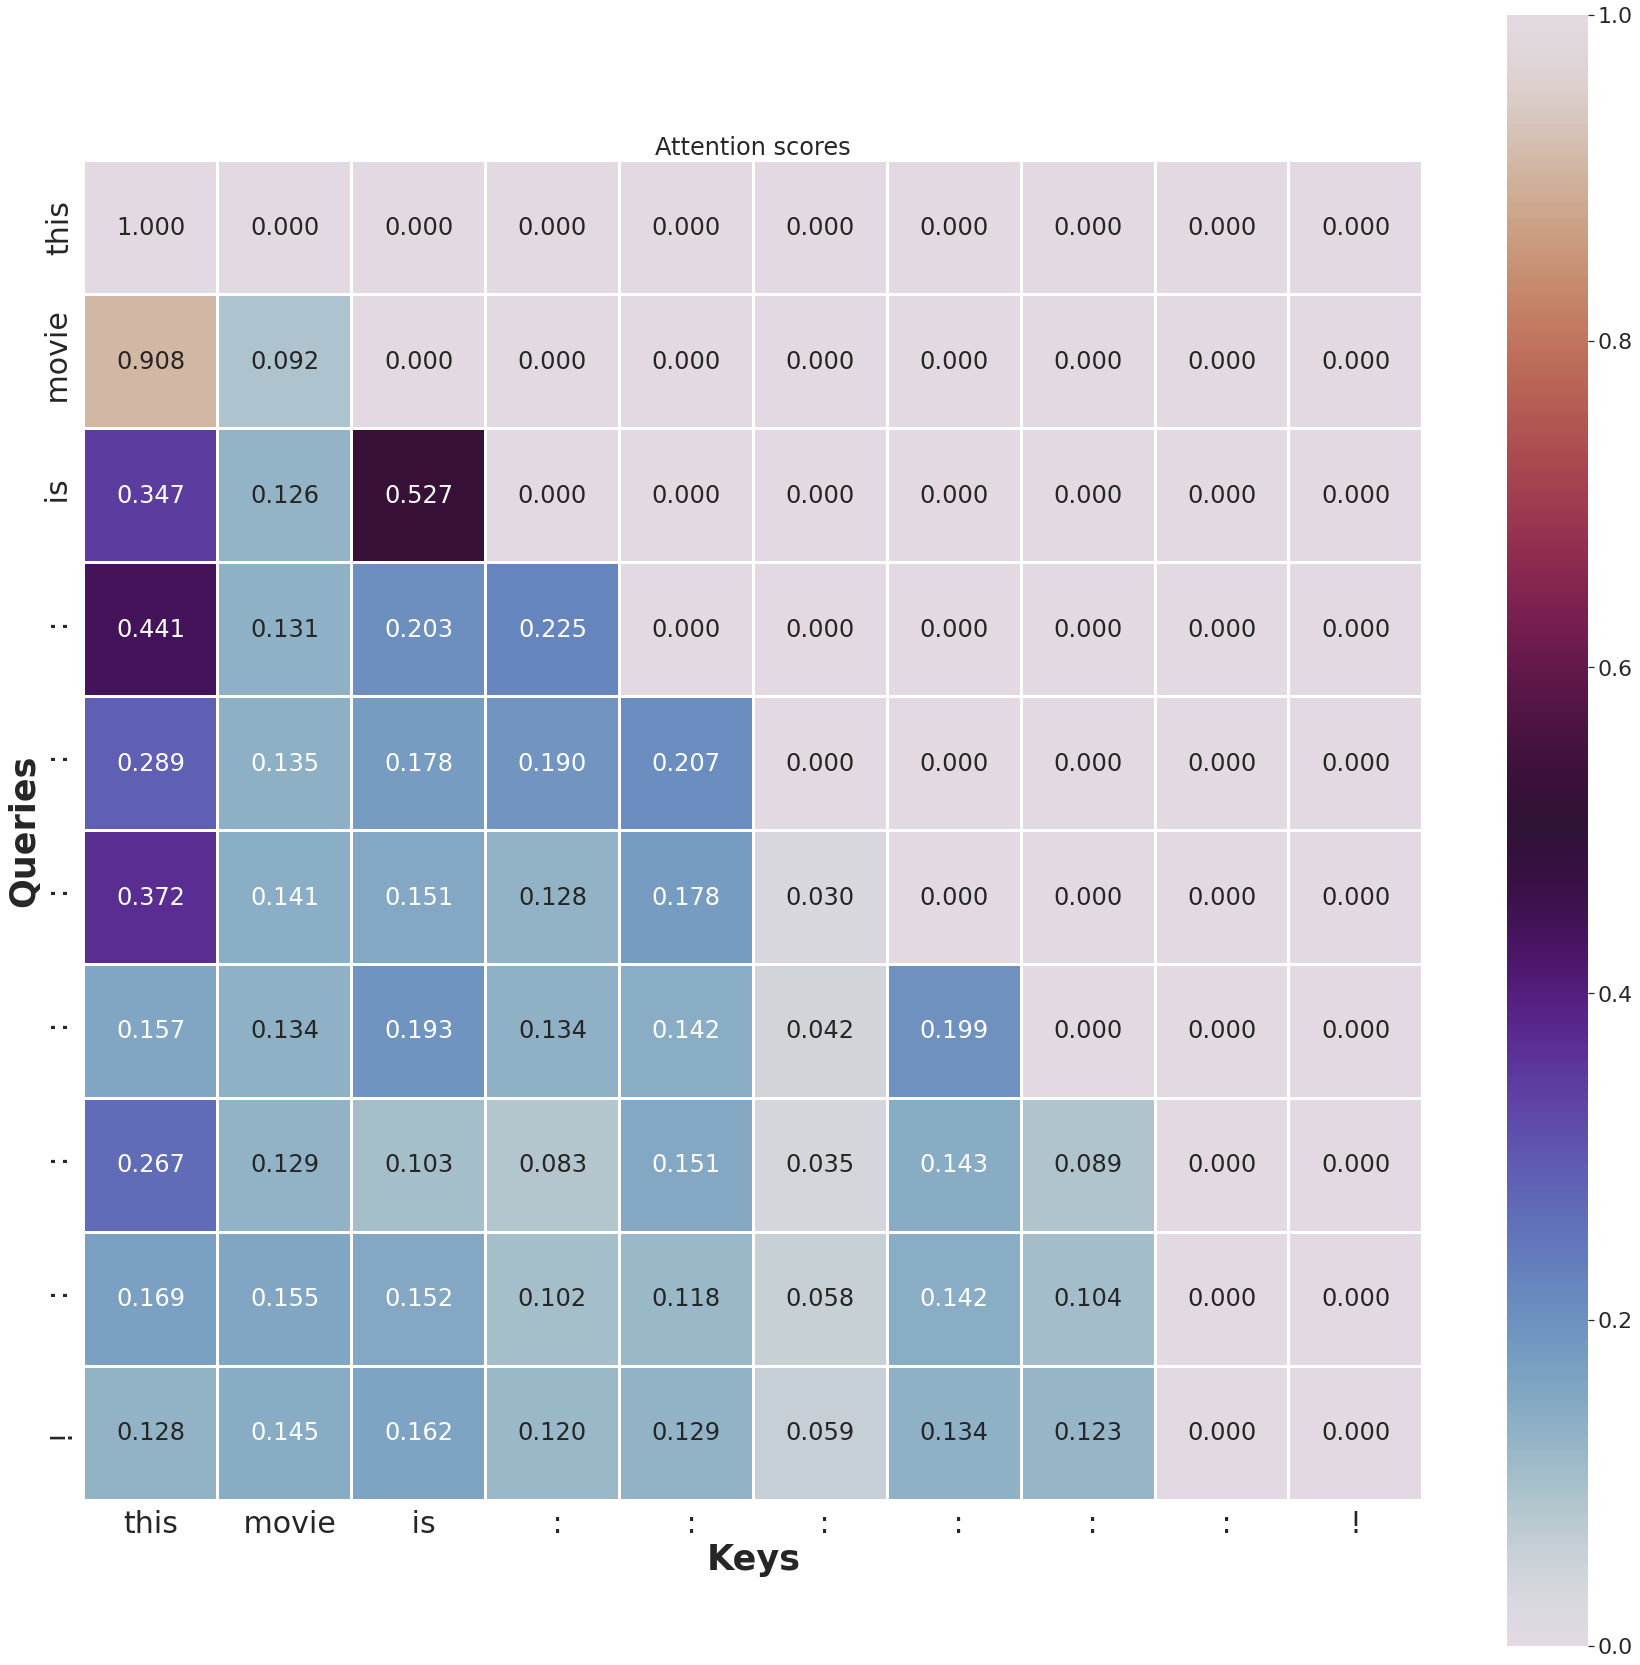

In [34]:
dfx = pd.DataFrame(ret_txt[:10], columns =['Keys'] );
dfy2=pd.DataFrame(score[7, :10, :10],index=ret_txt[:10],columns=ret_txt[:10]);
plt.figure(figsize=(30.0,30.0));
b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
b.set_yticklabels(ret_txt[:10], size = 30)
b.set_xticklabels(ret_txt[:10], size = 30)
sns.set(font_scale=2)
plt.title("Attention scores");
plt.xlabel('Keys',size=maxlen, fontsize=35, fontweight='bold');
plt.ylabel('Queries',size=maxlen, fontsize=35, fontweight='bold');
plt.plot();
plt.savefig("./attn/attn_7.jpg")

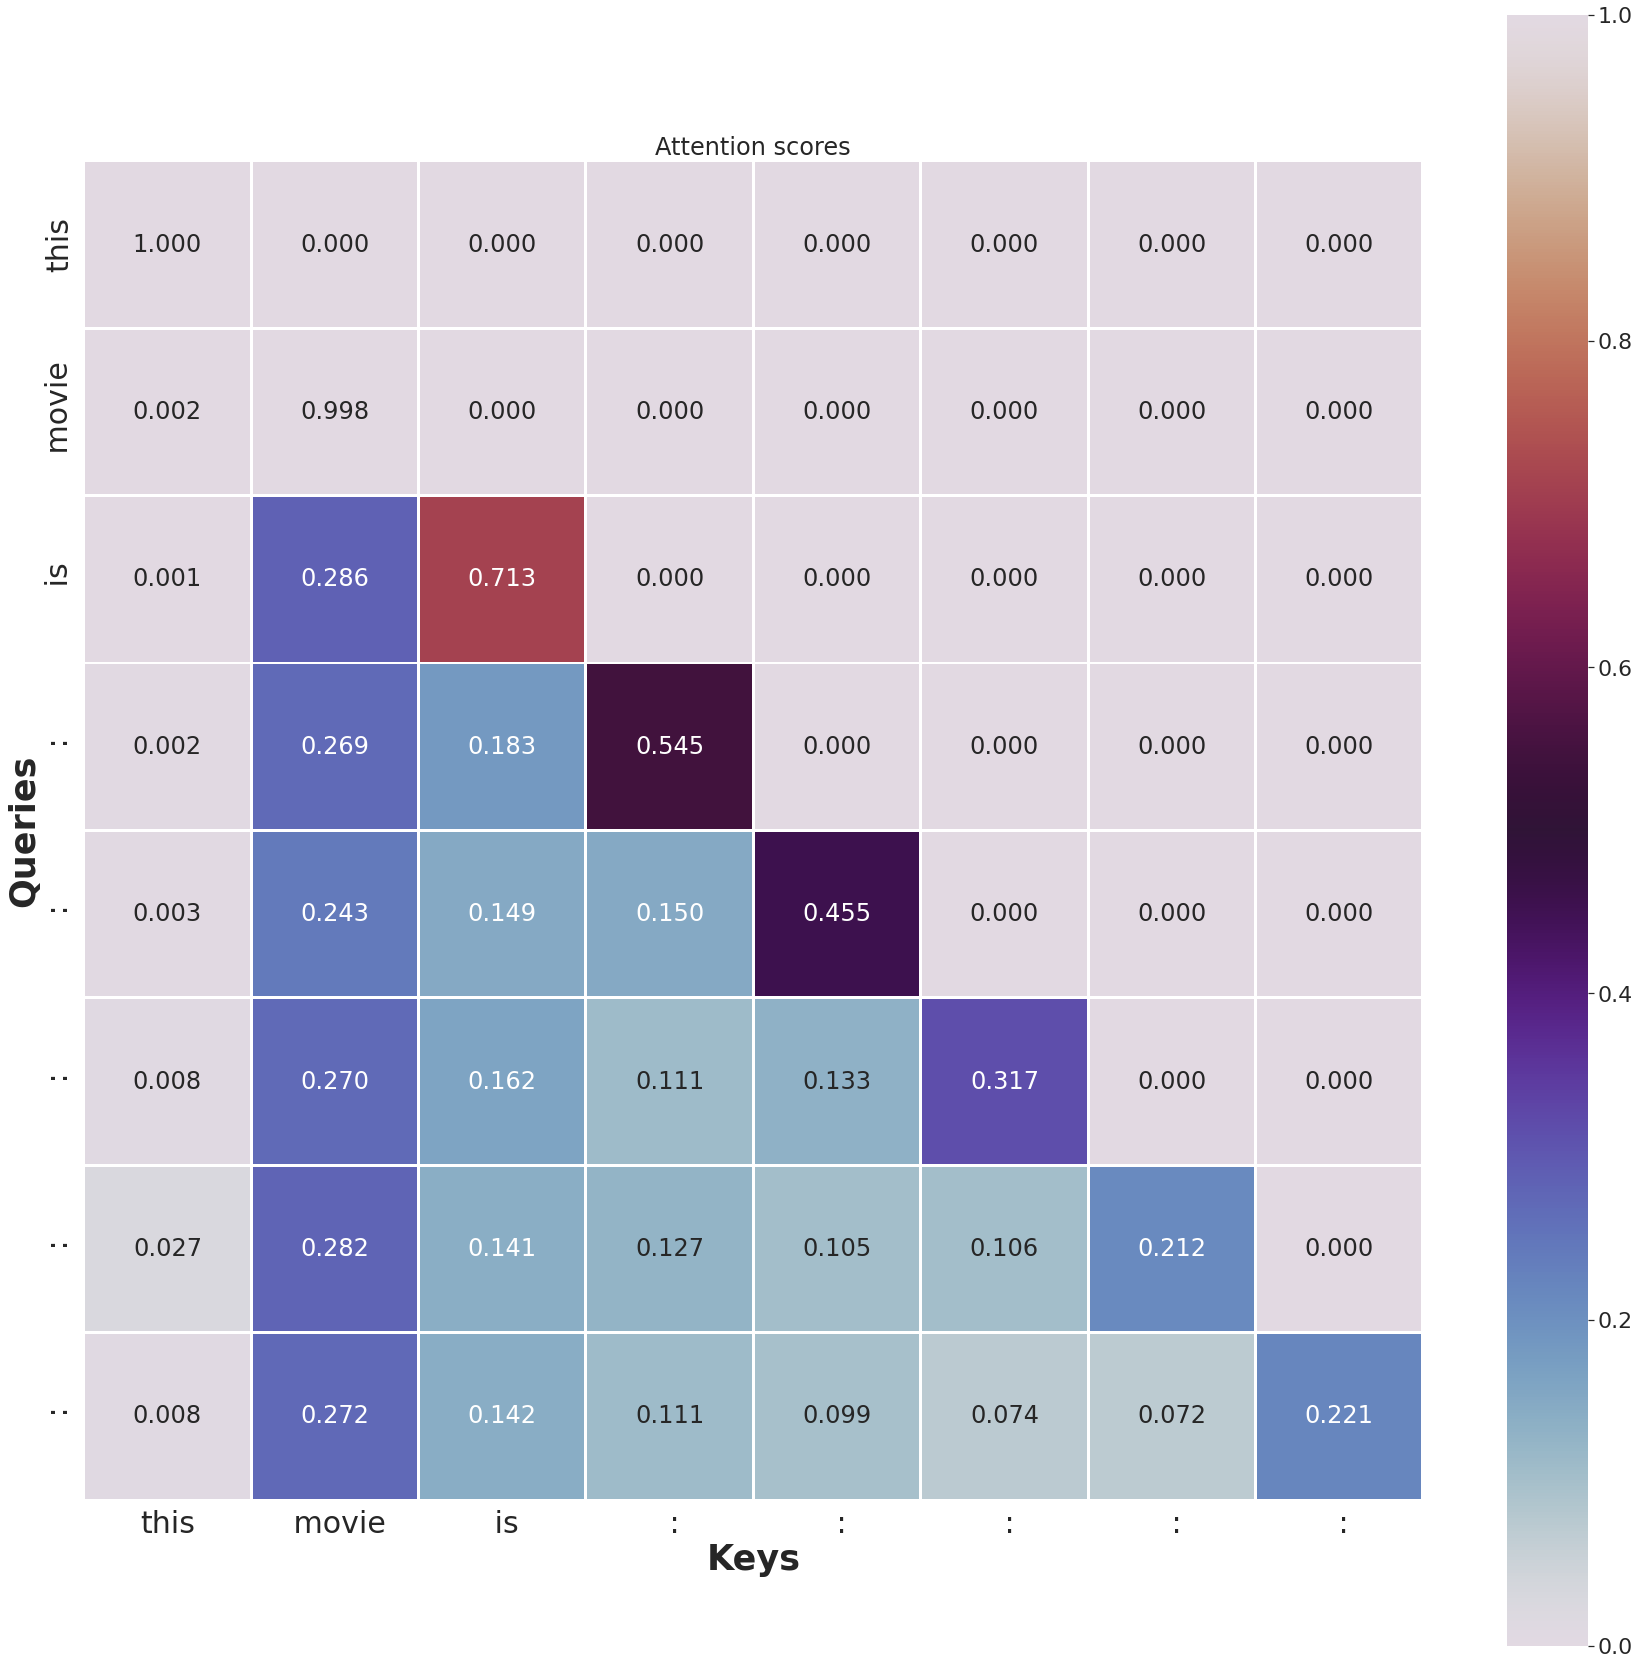

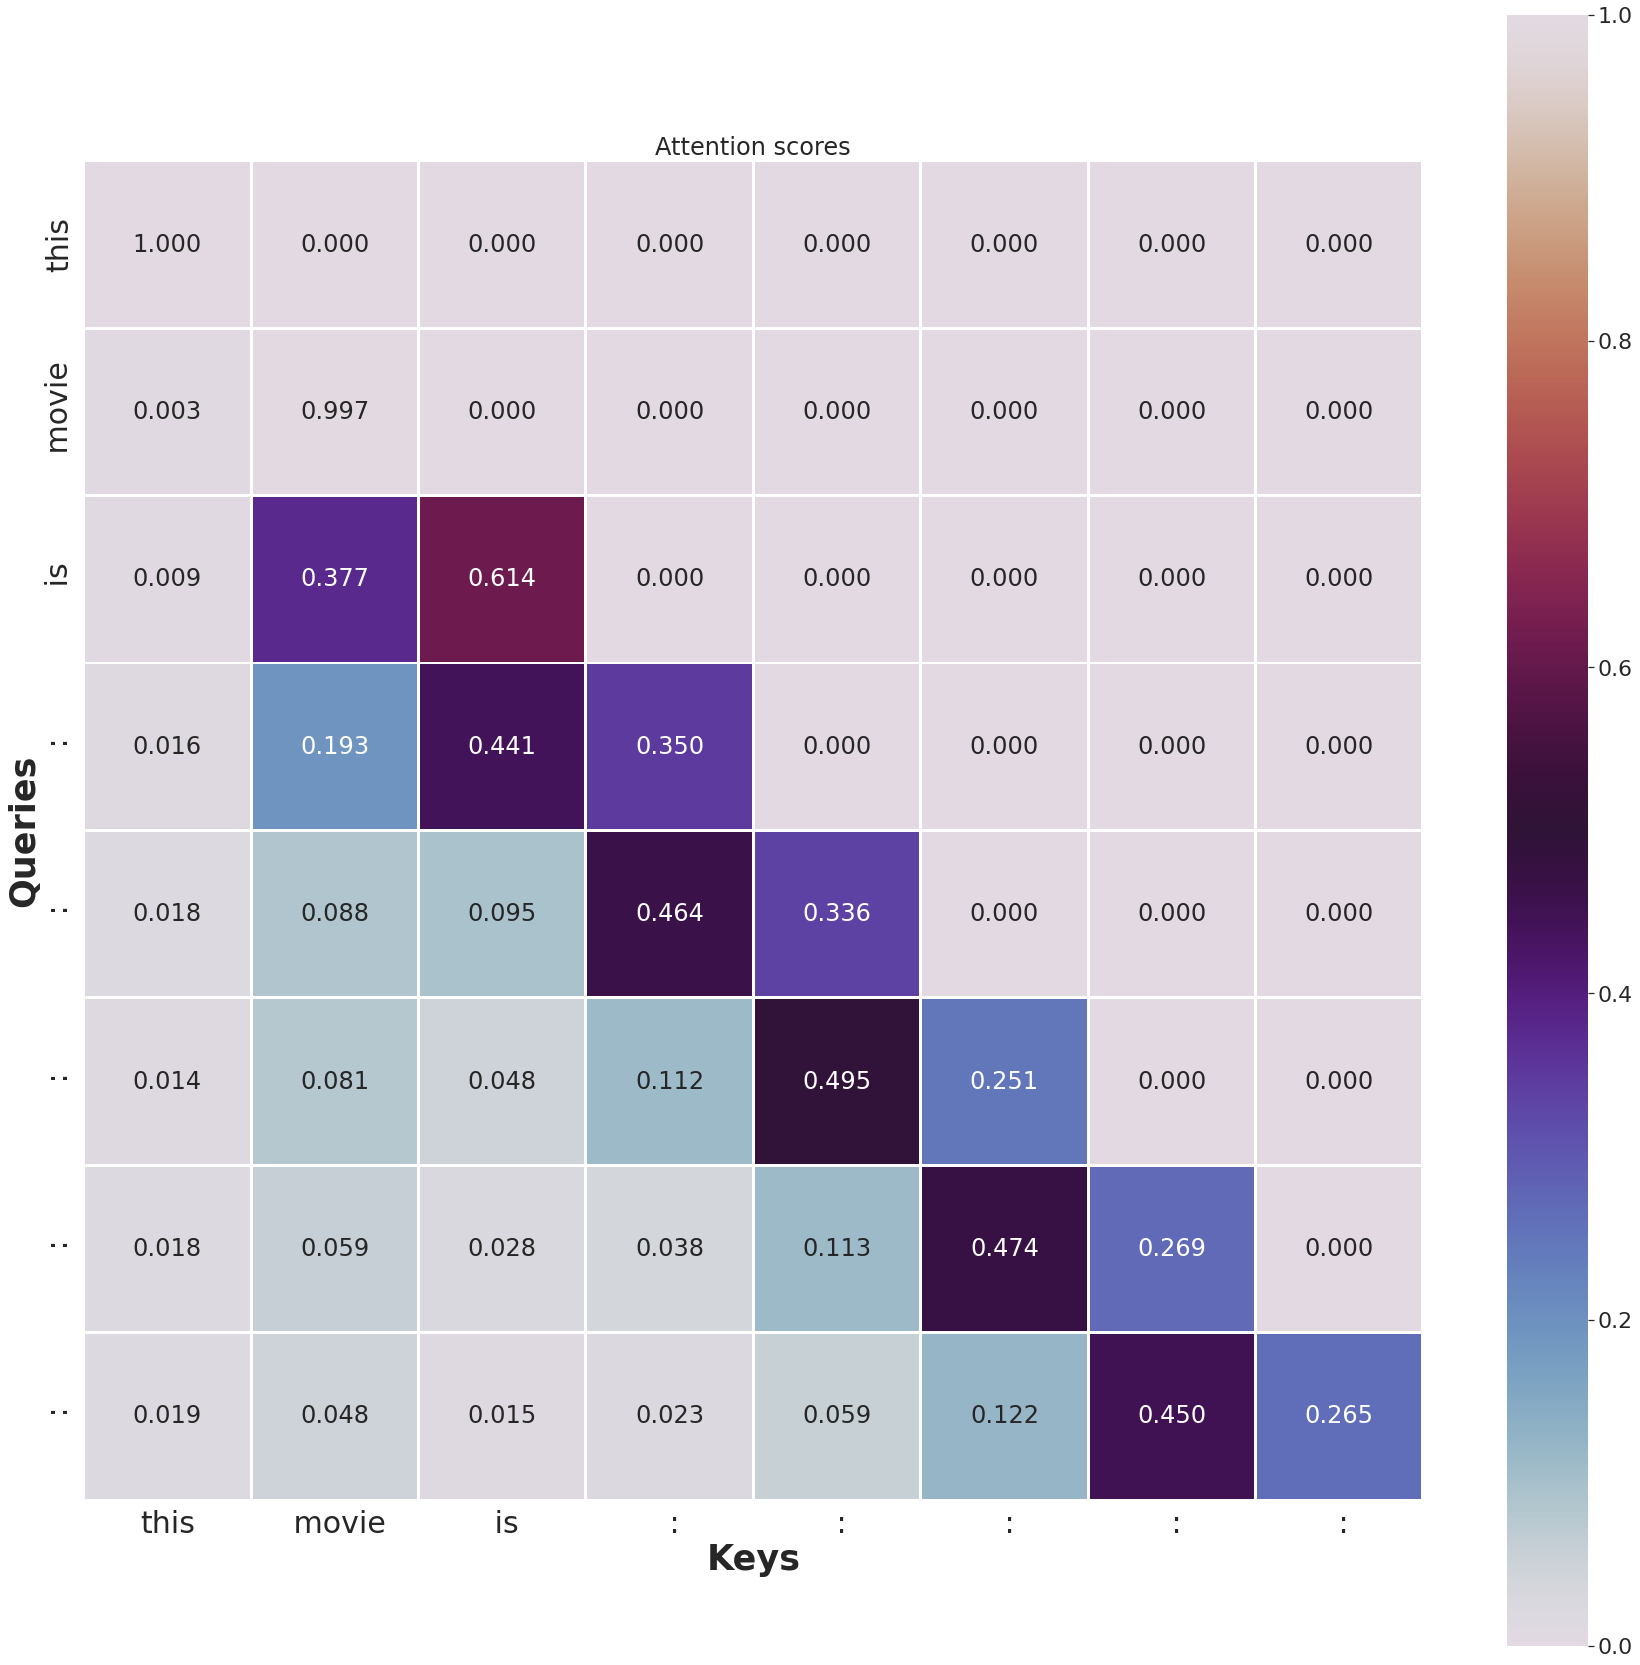

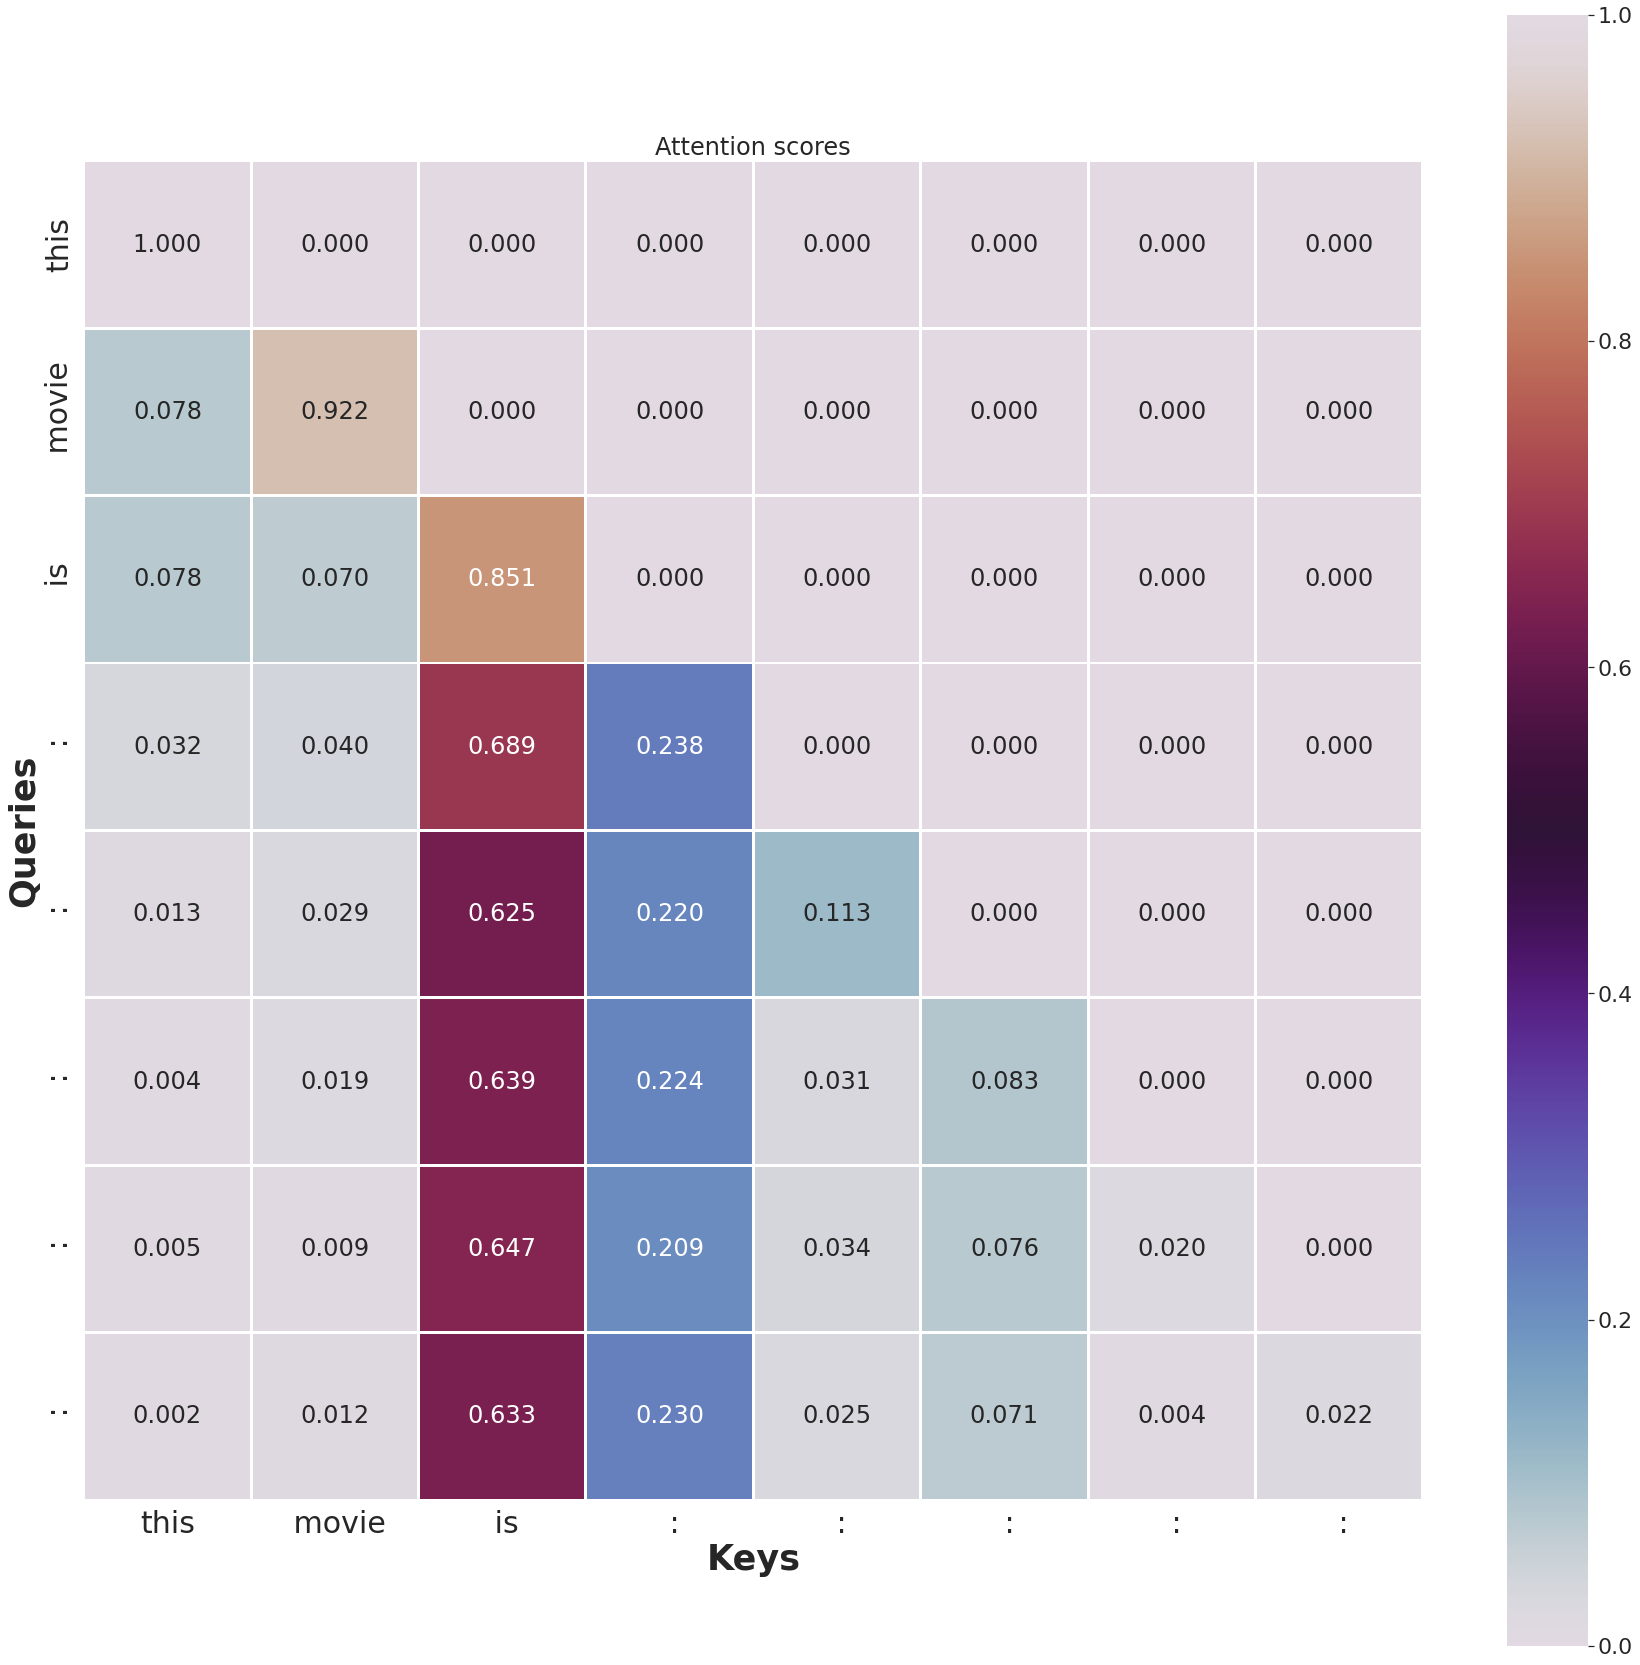

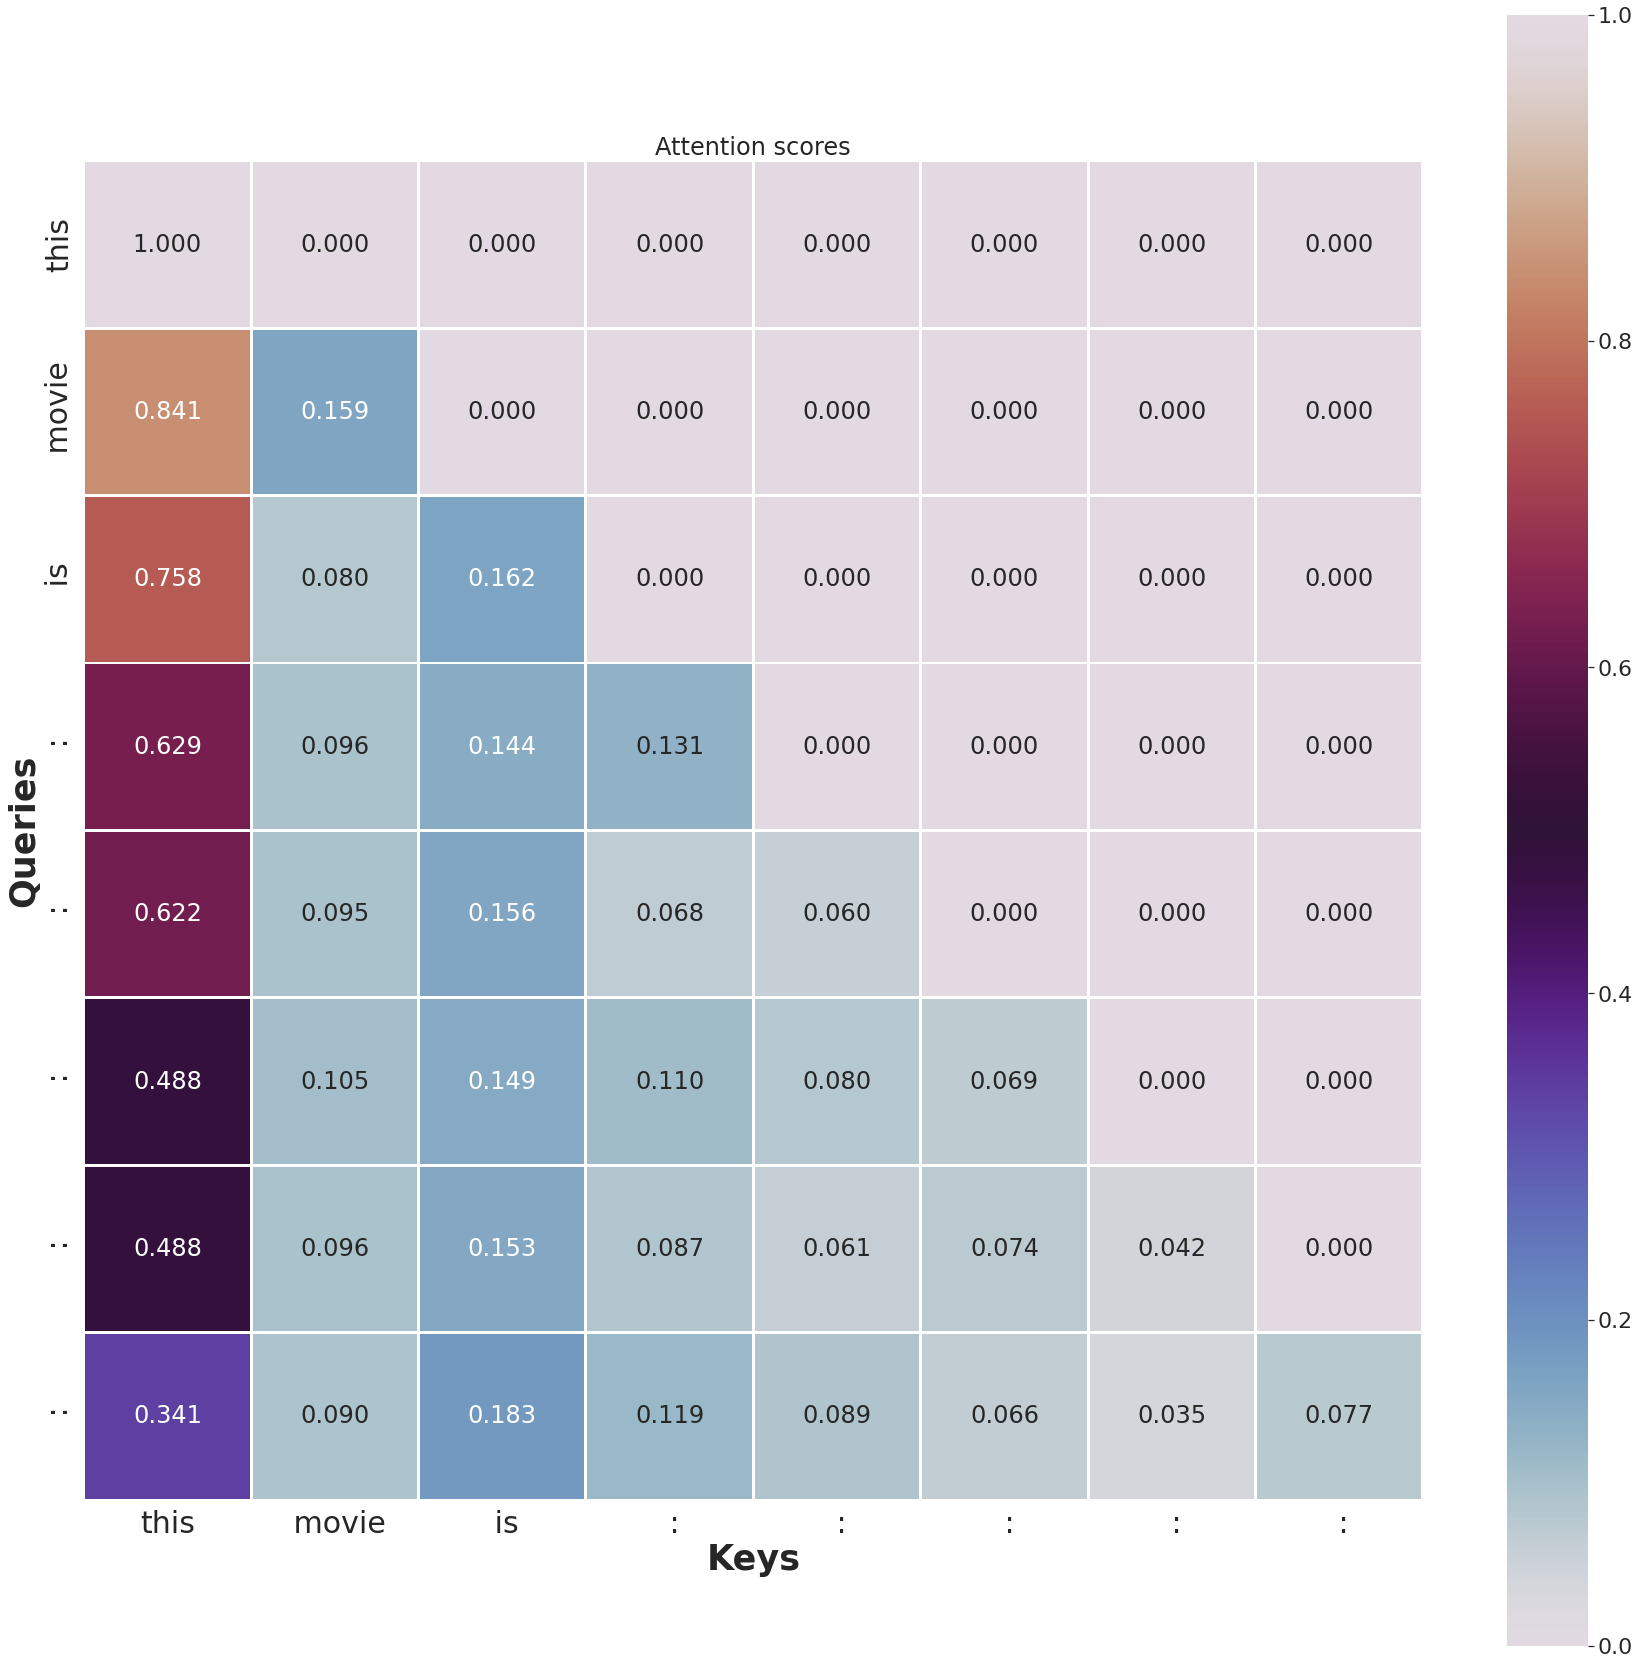

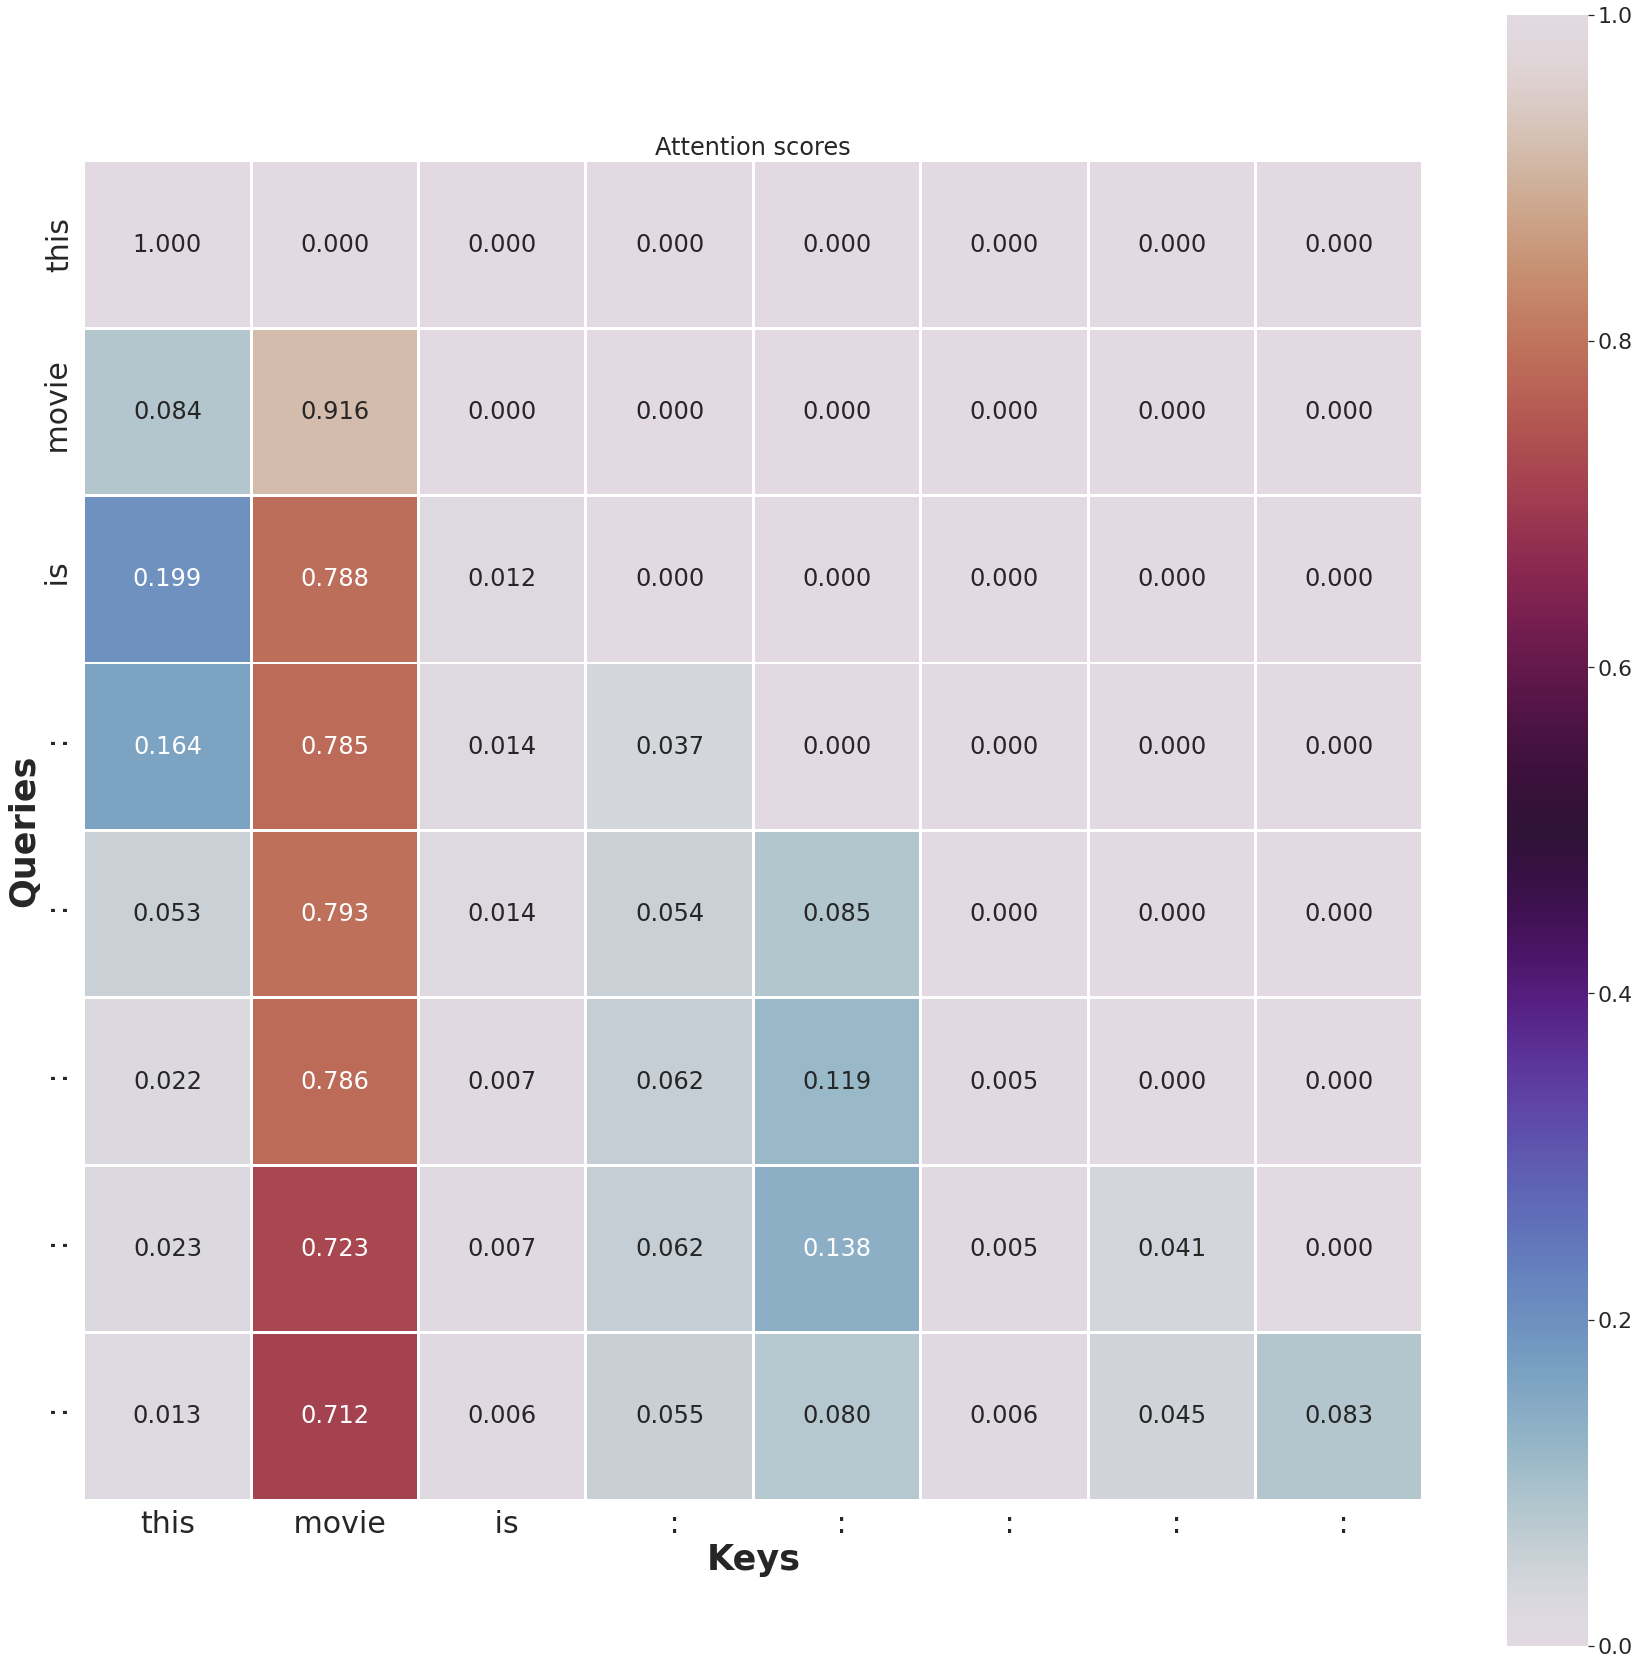

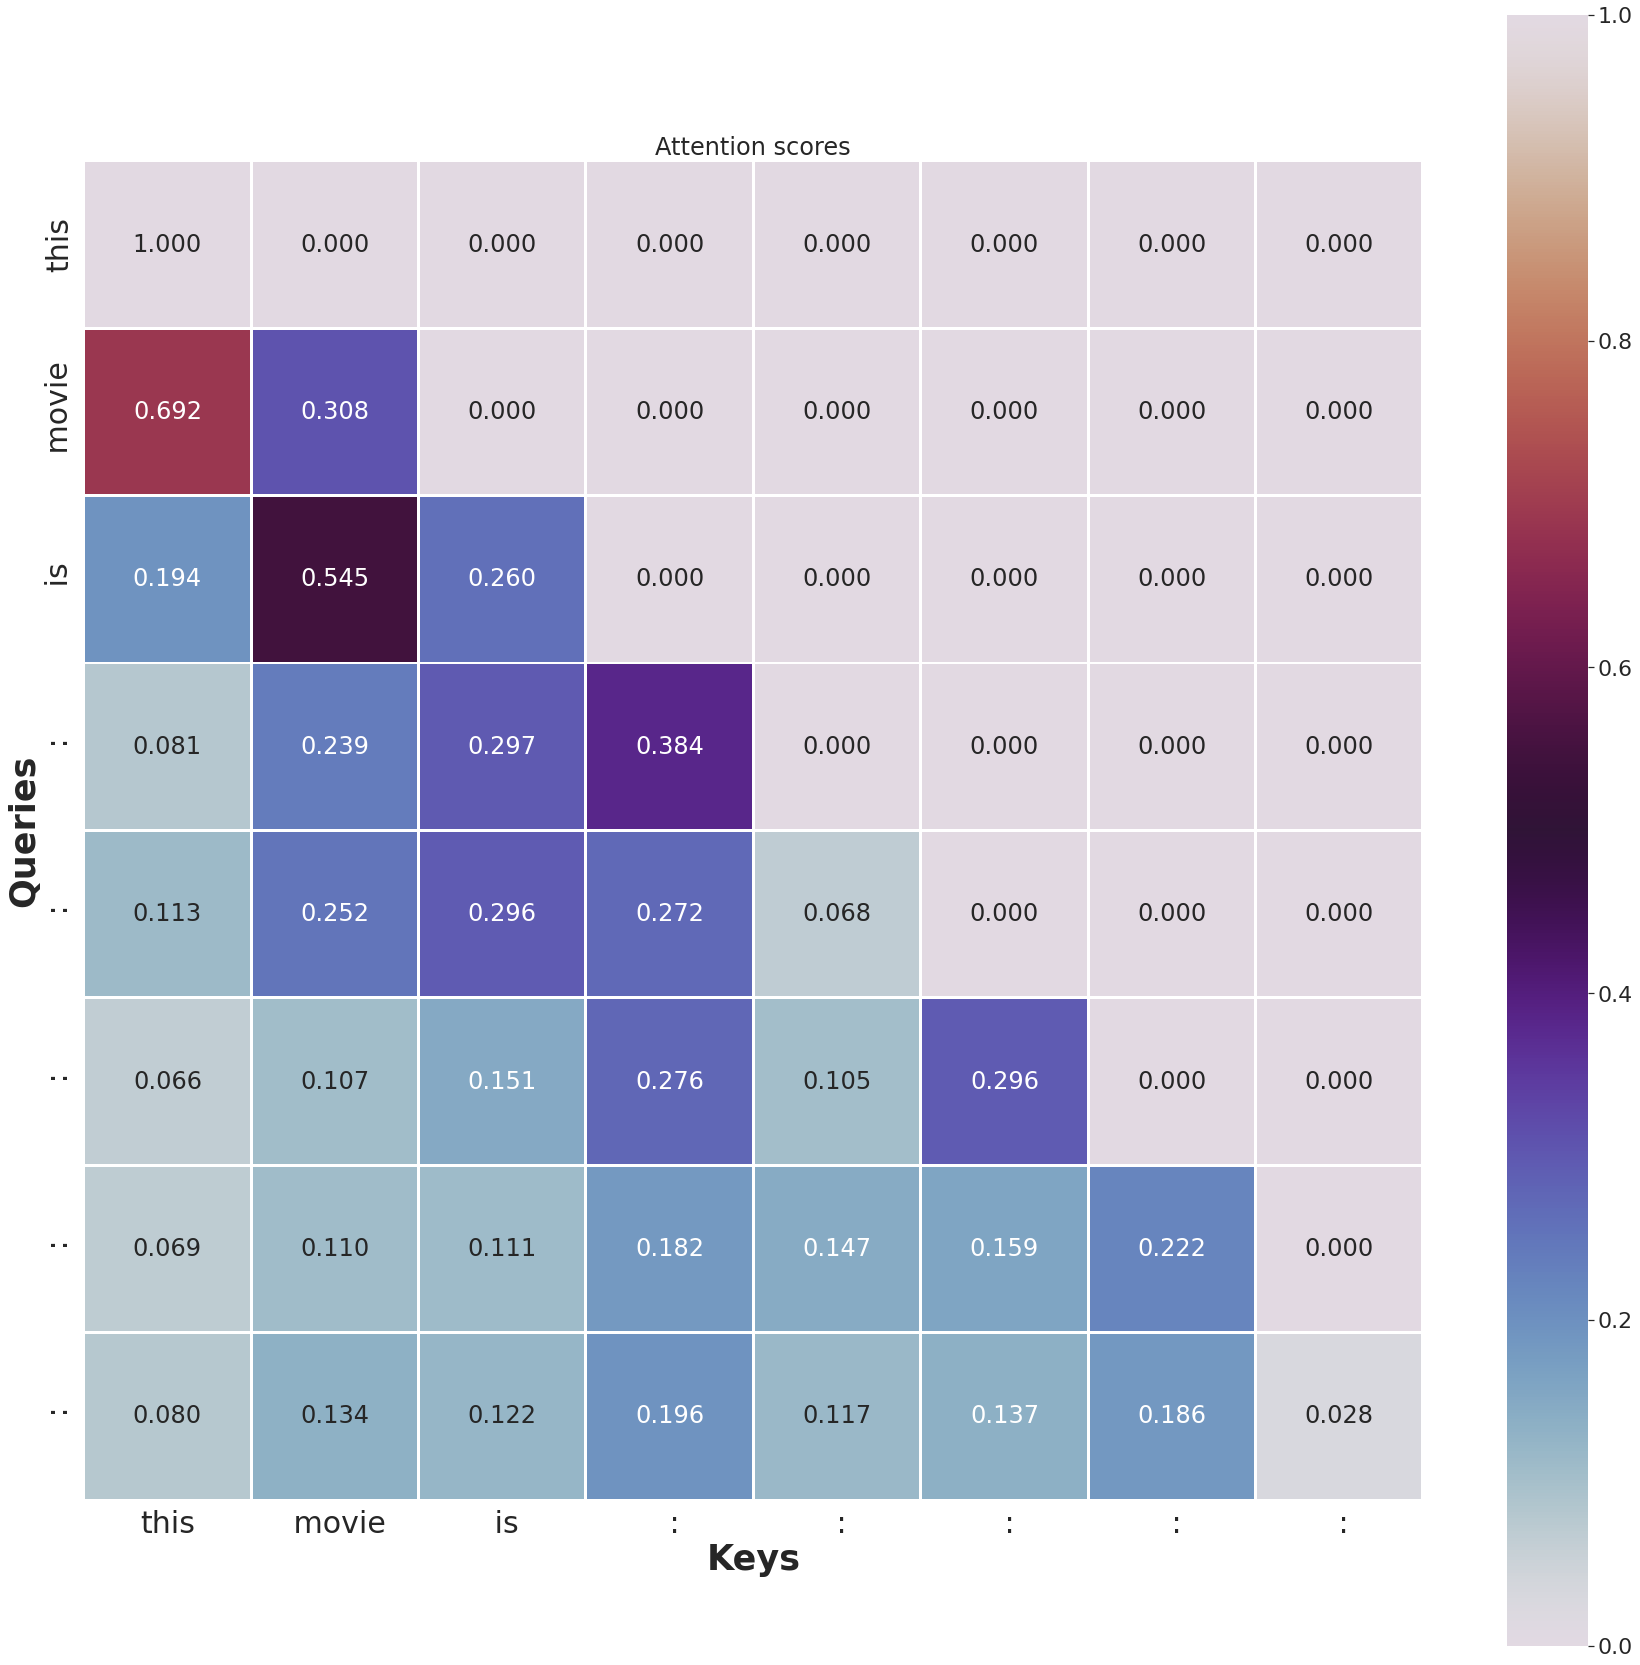

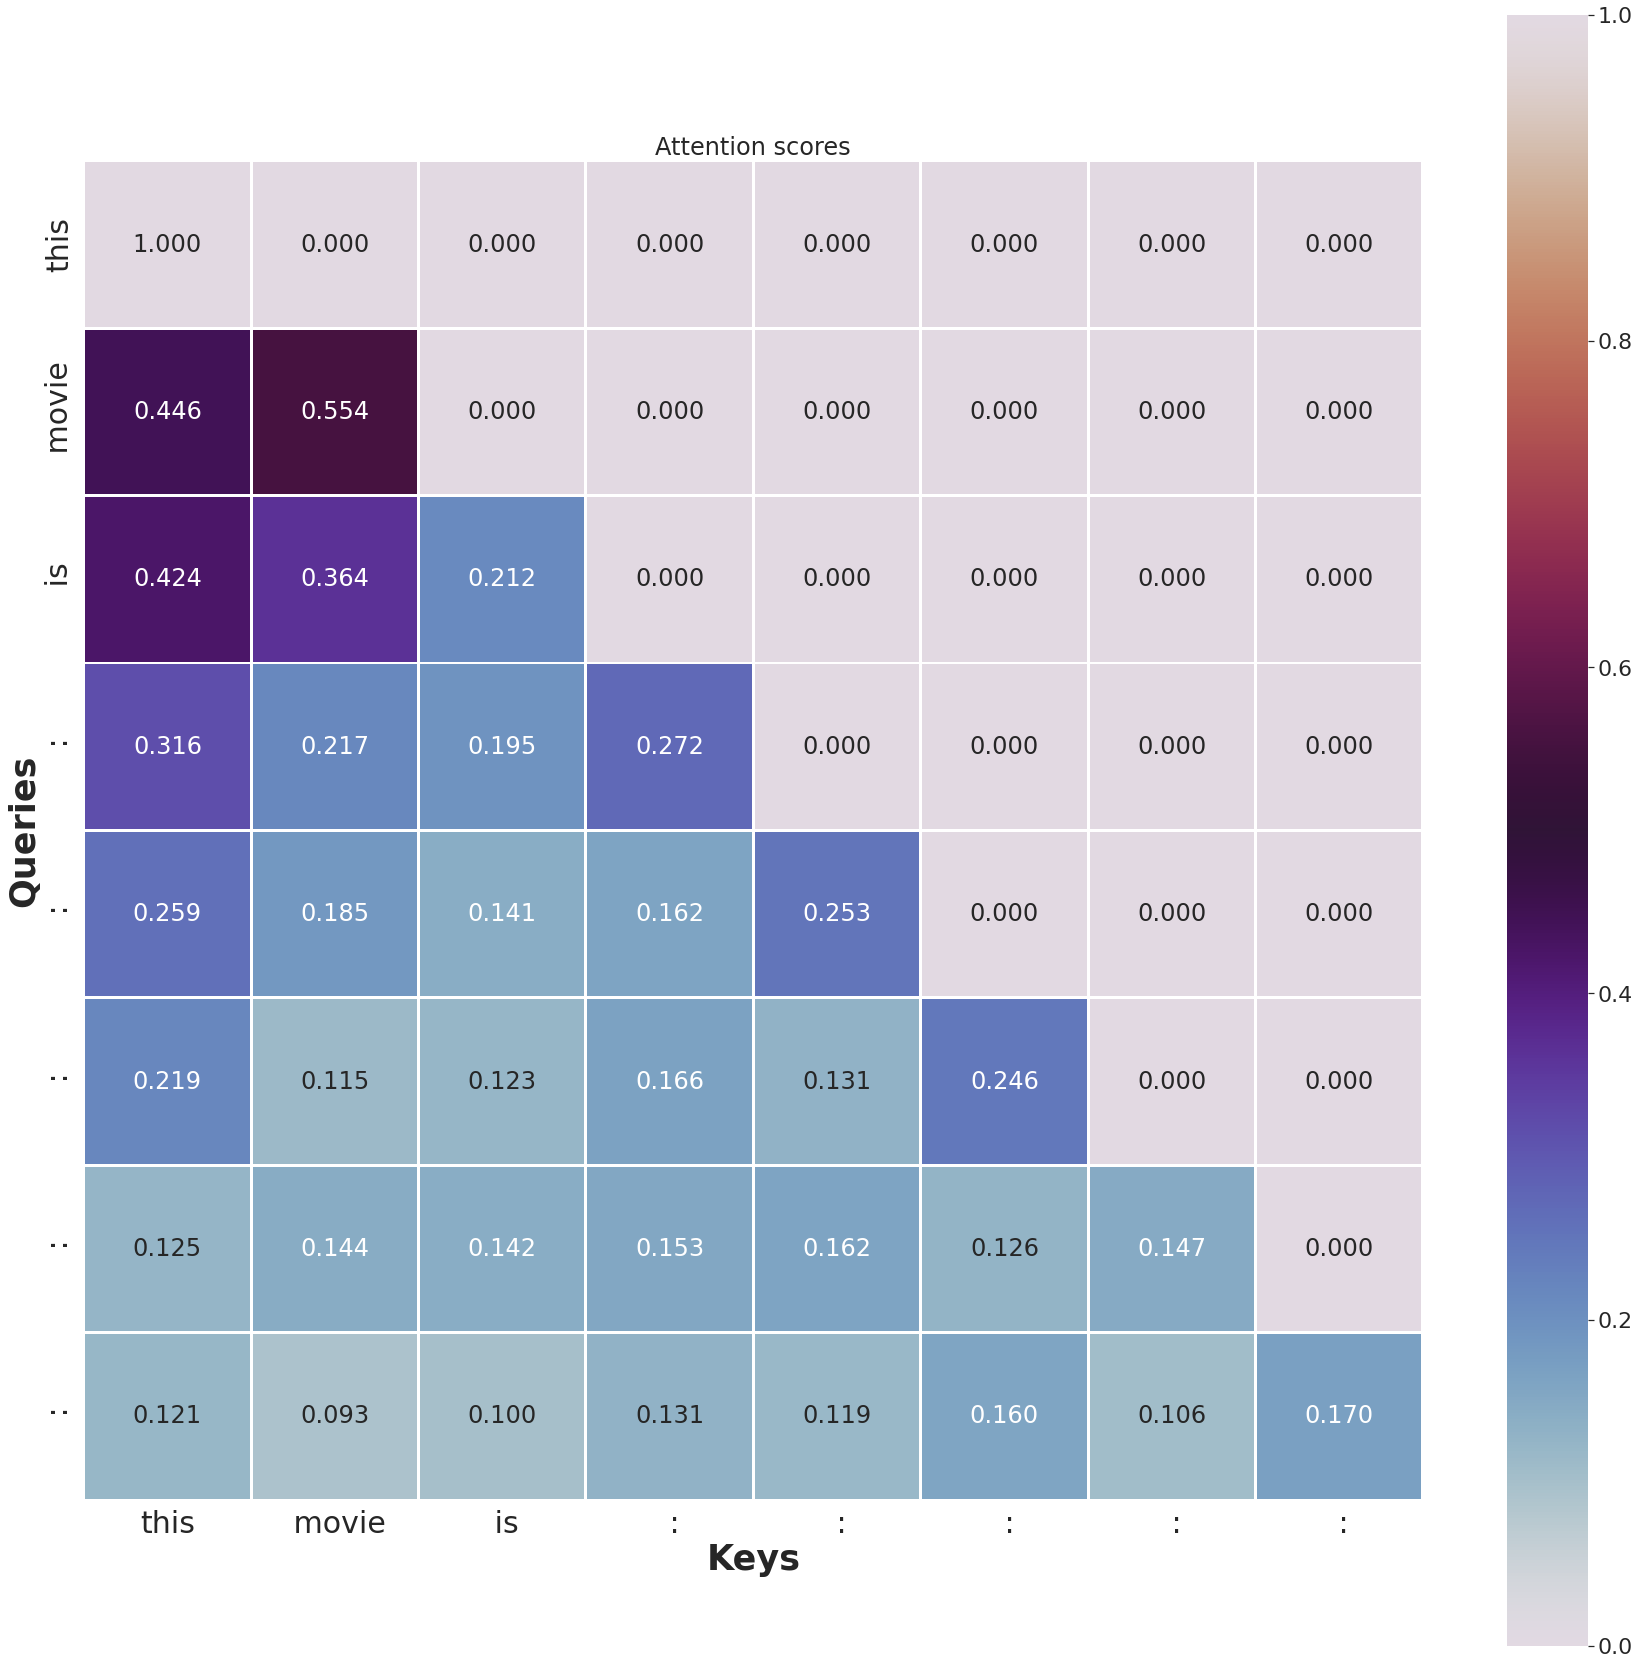

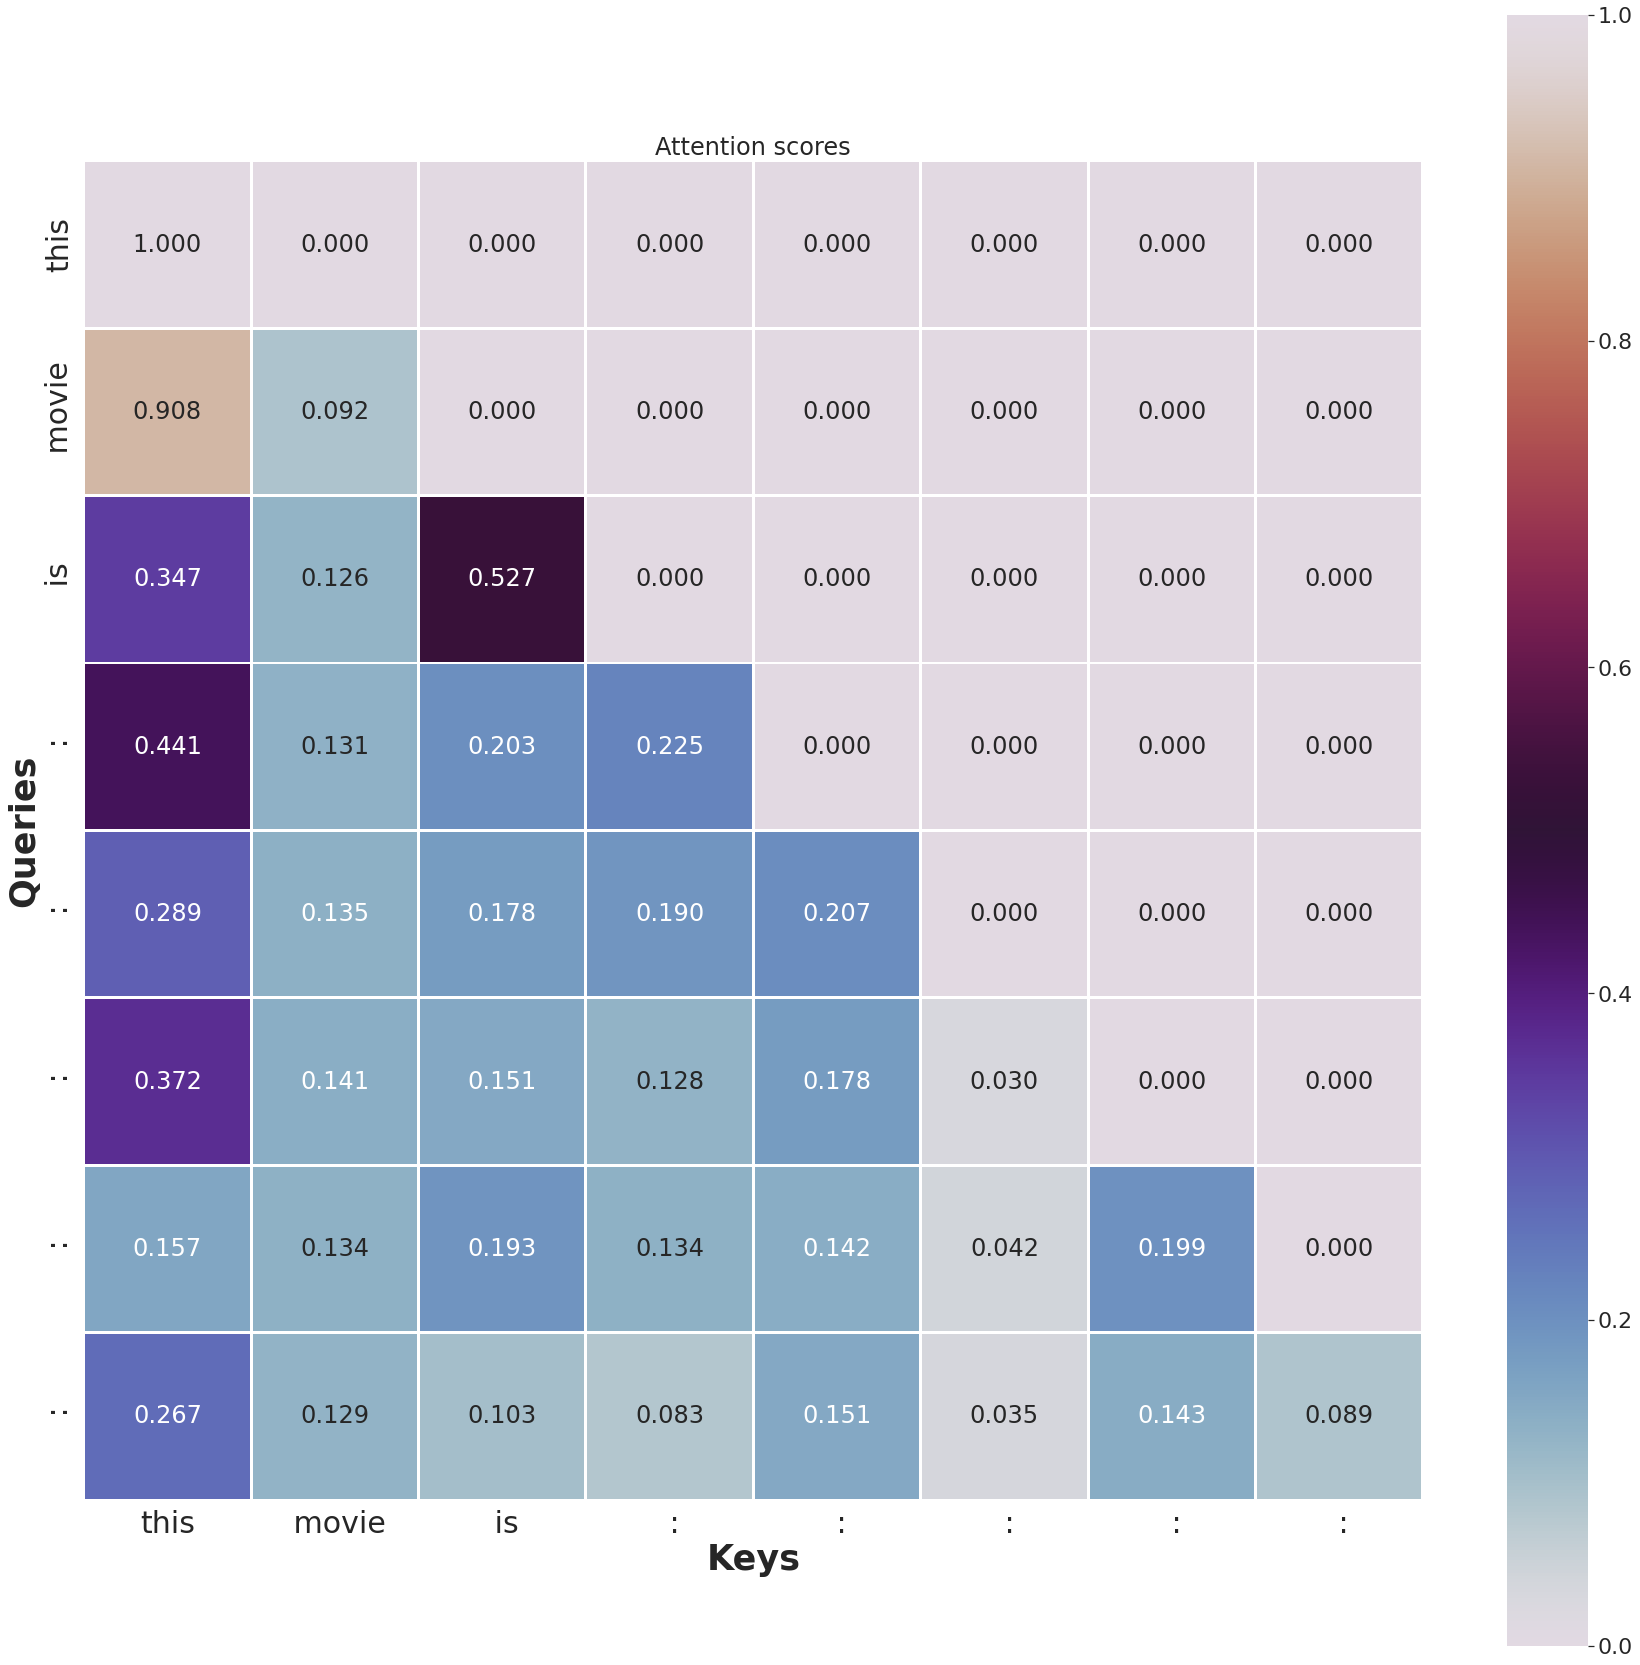

In [35]:
for i in range(8):
    dfx = pd.DataFrame(ret_txt[:8], columns =['Keys'] );
    dfy2=pd.DataFrame(score[i, :8, :8],index=ret_txt[:8],columns=ret_txt[:8]);
    plt.figure(figsize=(30.0,30.0));
    b = sns.heatmap(dfy2,fmt=".3f",annot=True,linewidths=2,square=True,cmap='twilight');
    b.set_yticklabels(ret_txt[:8], size = 30)
    b.set_xticklabels(ret_txt[:8], size = 30)
    sns.set(font_scale=2)
    plt.title("Attention scores");
    plt.xlabel('Keys',size=maxlen, fontsize=35, fontweight='bold');
    plt.ylabel('Queries',size=maxlen, fontsize=35, fontweight='bold');
    plt.plot();
    plt.savefig(f"./attn/attn_{i}.jpg")